In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_folder="/content/drive/MyDrive/take3"

In [ ]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm import tqdm
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

Downloading the Closing Prices

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/take3/ind_nifty500list_filtered_final.csv')
os.makedirs(f"{drive_folder}/stock_data", exist_ok=True)
os.makedirs(f"{drive_folder}/stock_data/train", exist_ok=True)
os.makedirs(f"{drive_folder}/stock_data/test", exist_ok=True)
os.makedirs(f"{drive_folder}/stock_data/val", exist_ok=True)

valid_tickers_file = f"{drive_folder}/valid_tickers.csv"
pkl_file_path = f"{drive_folder}/stock_data/nifty500_stock_data.pkl"

nifty500_stock_data = {}
valid_tickers = []
invalid_tickers = []

df_tickers = df['Symbol'] + '.NS'

if os.path.exists(pkl_file_path):
    print("Loading existing stock data from Google Drive...")
    with open(pkl_file_path, 'rb') as file:
        nifty500_stock_data = pickle.load(file)
    print("Stock data loaded successfully.")
else:
    print("No data found so Fetching new stock data...")
    ticker_data_lengths = {}

    for ticker in tqdm(df_tickers[:500], desc="Downloading "):
        try:
            stock = yf.Ticker(ticker)
            company_history = stock.history(start="2022-01-10", end="2025-01-11")

            if not company_history.empty:
                valid_tickers.append(ticker.replace('.NS', ''))
                if hasattr(company_history.index, "tz_localize"):
                    company_history.index = company_history.index.tz_localize(None)

                # Reset index and remove unwanted columns
                company_history = company_history.reset_index().drop(columns=['Dividends', 'Stock Splits'], errors='ignore')
                company_history = company_history.drop(columns=['Open', 'High', 'Low', 'Volume'], errors='ignore')
                ticker_data_lengths[ticker] = len(company_history)
                print(f"📊 {ticker} has {len(company_history)} days of data.")


                # Create labels
                company_history['Label'] = (company_history['Close'].shift(-1) > company_history['Close']).astype(int)
                company_history = company_history.dropna(subset=['Label'])

                # Feature Engineering
                company_history['Return'] = company_history['Close'].pct_change()
                company_history = company_history.fillna(0)

                # Normalize features
                price_features = ['Close', 'Return']

                scaler_price =  StandardScaler()
                company_history['nor_Close'] = scaler_price.fit_transform(company_history[['Close']])

                # Split into Train, Validation, Test (70%, 15%, 15%)
                total_required = 400 + 160 + 182  # 720 days
                if len(company_history) >= total_required:
                    company_history = company_history[-total_required:]  # take most recent 720 days

                    train_data = company_history[:400]
                    val_data = company_history[400:560]
                    test_data = company_history[560:]
                else:
                    print(f"❌ Not enough data for {ticker}. Only {len(company_history)} days available.")
                    invalid_tickers.append(ticker)
                    continue

                # Save in dictionary
                nifty500_stock_data[ticker] = {
                    'train': train_data,
                    'validation': val_data,
                    'test': test_data
                }

                # Save individual stock CSVs
                stock_csv_path_train = f"{drive_folder}/stock_data/train/{ticker.replace('.NS', '')}_train.csv"
                stock_csv_path_val = f"{drive_folder}/stock_data/val/{ticker.replace('.NS', '')}_val.csv"
                stock_csv_path_test = f"{drive_folder}/stock_data/test/{ticker.replace('.NS', '')}_test.csv"
                train_data.to_csv(stock_csv_path_train, index=False)
                val_data.to_csv(stock_csv_path_val, index=False)
                test_data.to_csv(stock_csv_path_test, index=False)
            else:
                invalid_tickers.append(ticker)
                print(f"No data available for {ticker}.")
        except Exception as e:
            invalid_tickers.append(ticker)
            print(f"Error fetching data for {ticker}: {e}")
# Save valid tickers list
valid_tickers_df = pd.DataFrame(valid_tickers, columns=['Symbol'])
valid_tickers_df.to_csv(valid_tickers_file, index=False)
# Save stock data dictionary
with open(pkl_file_path, 'wb') as file:
    pickle.dump(nifty500_stock_data, file)
print("\n✅ Stock data processing complete and saved to Google Drive.")
# Summary
print(f"✅ Valid tickers: {len(valid_tickers)}")
print(f"❌ Invalid tickers: {len(invalid_tickers)}")
print(f"❌ Invalid tickers list: {invalid_tickers}")


No data found so Fetching new stock data...


📊 360ONE.NS has 742 days of data.


📊 ABB.NS has 742 days of data.


📊 ACC.NS has 742 days of data.


📊 AIAENG.NS has 742 days of data.


📊 APLAPOLLO.NS has 742 days of data.


📊 AUBANK.NS has 742 days of data.


📊 AARTIIND.NS has 742 days of data.


📊 AAVAS.NS has 742 days of data.


📊 ABBOTINDIA.NS has 742 days of data.


📊 ACE.NS has 742 days of data.


📊 ADANIENT.NS has 742 days of data.
📊 ADANIGREEN.NS has 742 days of data.


📊 ADANIPORTS.NS has 742 days of data.


📊 ADANIPOWER.NS has 742 days of data.


📊 ATGL.NS has 742 days of data.


📊 ABCAPITAL.NS has 742 days of data.


📊 ABFRL.NS has 742 days of data.


📊 ABSLAMC.NS has 742 days of data.


📊 AFFLE.NS has 742 days of data.


📊 AJANTPHARM.NS has 742 days of data.
📊 APLLTD.NS has 742 days of data.


📊 ALKEM.NS has 742 days of data.


📊 ALKYLAMINE.NS has 742 days of data.


📊 ALOKINDS.NS has 742 days of data.


📊 AMBER.NS has 742 days of data.


📊 AMBUJACEM.NS has 742 days of data.


📊 ANANDRATHI.NS has 742 days of data.


📊 ANANTRAJ.NS has 742 days of data.


📊 ANGELONE.NS has 742 days of data.


📊 APARINDS.NS has 742 days of data.


📊 APOLLOHOSP.NS has 742 days of data.


📊 APOLLOTYRE.NS has 742 days of data.


📊 APTUS.NS has 742 days of data.


📊 ASAHIINDIA.NS has 742 days of data.


📊 ASHOKLEY.NS has 742 days of data.


📊 ASIANPAINT.NS has 742 days of data.


📊 ASTERDM.NS has 742 days of data.


📊 ASTRAZEN.NS has 742 days of data.


📊 ASTRAL.NS has 742 days of data.


📊 ATUL.NS has 742 days of data.


📊 AUROPHARMA.NS has 742 days of data.


📊 AVANTIFEED.NS has 742 days of data.


📊 DMART.NS has 742 days of data.


📊 AXISBANK.NS has 742 days of data.


📊 BASF.NS has 742 days of data.


📊 BEML.NS has 742 days of data.


📊 BLS.NS has 742 days of data.


📊 BSE.NS has 742 days of data.


📊 BAJAJ-AUTO.NS has 742 days of data.


📊 BAJFINANCE.NS has 742 days of data.


📊 BAJAJFINSV.NS has 742 days of data.


📊 BAJAJHLDNG.NS has 742 days of data.


📊 BALAMINES.NS has 742 days of data.


📊 BALKRISIND.NS has 742 days of data.


📊 BALRAMCHIN.NS has 742 days of data.


📊 BANDHANBNK.NS has 742 days of data.


📊 BANKBARODA.NS has 742 days of data.


📊 BANKINDIA.NS has 742 days of data.


📊 MAHABANK.NS has 742 days of data.


📊 BATAINDIA.NS has 742 days of data.


📊 BAYERCROP.NS has 742 days of data.


📊 BERGEPAINT.NS has 742 days of data.


📊 BDL.NS has 742 days of data.


📊 BEL.NS has 742 days of data.


📊 BHARATFORG.NS has 742 days of data.


📊 BHEL.NS has 742 days of data.


📊 BPCL.NS has 742 days of data.


📊 BHARTIARTL.NS has 742 days of data.
📊 BIOCON.NS has 742 days of data.


📊 BIRLACORPN.NS has 742 days of data.


📊 BSOFT.NS has 742 days of data.


📊 BLUEDART.NS has 742 days of data.


📊 BLUESTARCO.NS has 742 days of data.


📊 BBTC.NS has 742 days of data.


📊 BOSCHLTD.NS has 742 days of data.


📊 BRITANNIA.NS has 742 days of data.


📊 MAPMYINDIA.NS has 742 days of data.


📊 CCL.NS has 742 days of data.


📊 CESC.NS has 742 days of data.


📊 CGPOWER.NS has 742 days of data.


📊 CIEINDIA.NS has 742 days of data.


📊 CRISIL.NS has 742 days of data.


📊 CANFINHOME.NS has 742 days of data.


📊 CANBK.NS has 742 days of data.


📊 CAPLIPOINT.NS has 742 days of data.


📊 CGCL.NS has 742 days of data.


📊 CARBORUNIV.NS has 742 days of data.


📊 CASTROLIND.NS has 742 days of data.


📊 CEATLTD.NS has 742 days of data.


📊 CENTRALBK.NS has 742 days of data.


📊 CDSL.NS has 742 days of data.


📊 CENTURYPLY.NS has 742 days of data.


📊 CERA.NS has 742 days of data.


📊 CHALET.NS has 742 days of data.


📊 CHAMBLFERT.NS has 742 days of data.


📊 CHEMPLASTS.NS has 742 days of data.


📊 CHENNPETRO.NS has 742 days of data.


📊 CHOLAHLDNG.NS has 742 days of data.


📊 CHOLAFIN.NS has 742 days of data.


📊 CIPLA.NS has 742 days of data.


📊 CUB.NS has 742 days of data.


📊 CLEAN.NS has 742 days of data.


📊 COALINDIA.NS has 742 days of data.


📊 COCHINSHIP.NS has 742 days of data.


📊 COFORGE.NS has 742 days of data.


📊 COLPAL.NS has 742 days of data.


📊 CAMS.NS has 742 days of data.


📊 CONCOR.NS has 742 days of data.


📊 COROMANDEL.NS has 742 days of data.


📊 CRAFTSMAN.NS has 742 days of data.


📊 CREDITACC.NS has 742 days of data.


📊 CROMPTON.NS has 742 days of data.


📊 CUMMINSIND.NS has 742 days of data.


📊 CYIENT.NS has 742 days of data.


📊 DLF.NS has 742 days of data.


📊 DABUR.NS has 742 days of data.


📊 DALBHARAT.NS has 742 days of data.


📊 DATAPATTNS.NS has 742 days of data.


📊 DEEPAKFERT.NS has 742 days of data.


📊 DEEPAKNTR.NS has 742 days of data.


📊 DEVYANI.NS has 742 days of data.


📊 DIVISLAB.NS has 742 days of data.


📊 DIXON.NS has 742 days of data.


📊 LALPATHLAB.NS has 742 days of data.


📊 DRREDDY.NS has 742 days of data.


📊 EIDPARRY.NS has 742 days of data.


📊 EIHOTEL.NS has 742 days of data.


📊 EASEMYTRIP.NS has 742 days of data.


📊 EICHERMOT.NS has 742 days of data.


📊 ELECON.NS has 742 days of data.


📊 ELGIEQUIP.NS has 742 days of data.


📊 EMAMILTD.NS has 742 days of data.


📊 ENDURANCE.NS has 742 days of data.


📊 ENGINERSIN.NS has 742 days of data.


📊 EQUITASBNK.NS has 742 days of data.


📊 ERIS.NS has 742 days of data.


📊 ESCORTS.NS has 742 days of data.


📊 EXIDEIND.NS has 742 days of data.


📊 NYKAA.NS has 742 days of data.


📊 FEDERALBNK.NS has 742 days of data.


📊 FACT.NS has 742 days of data.


📊 FINEORG.NS has 742 days of data.


📊 FINCABLES.NS has 742 days of data.


📊 FINPIPE.NS has 742 days of data.


📊 FSL.NS has 742 days of data.


📊 FORTIS.NS has 742 days of data.


📊 GRINFRA.NS has 742 days of data.


📊 GAIL.NS has 742 days of data.


📊 GVT&D.NS has 742 days of data.


📊 GMRAIRPORT.NS has 742 days of data.


📊 GRSE.NS has 742 days of data.


📊 GICRE.NS has 742 days of data.


📊 GILLETTE.NS has 742 days of data.


📊 GLAND.NS has 742 days of data.


📊 GLAXO.NS has 742 days of data.


📊 GLENMARK.NS has 742 days of data.


📊 GPIL.NS has 742 days of data.


📊 GODFRYPHLP.NS has 742 days of data.


📊 GODREJAGRO.NS has 742 days of data.


📊 GODREJCP.NS has 742 days of data.


📊 GODREJPROP.NS has 742 days of data.


📊 GRANULES.NS has 742 days of data.


📊 GRAPHITE.NS has 742 days of data.


📊 GRASIM.NS has 742 days of data.


📊 GESHIP.NS has 742 days of data.


📊 GRINDWELL.NS has 742 days of data.


📊 GAEL.NS has 742 days of data.


📊 FLUOROCHEM.NS has 742 days of data.


📊 GUJGASLTD.NS has 742 days of data.


📊 GMDCLTD.NS has 742 days of data.


📊 GNFC.NS has 742 days of data.


📊 GPPL.NS has 742 days of data.


📊 GSFC.NS has 742 days of data.


📊 GSPL.NS has 742 days of data.


📊 HEG.NS has 742 days of data.


📊 HCLTECH.NS has 742 days of data.


📊 HDFCAMC.NS has 742 days of data.


📊 HDFCBANK.NS has 742 days of data.


📊 HDFCLIFE.NS has 742 days of data.


📊 HFCL.NS has 742 days of data.


📊 HAPPSTMNDS.NS has 742 days of data.


📊 HAVELLS.NS has 742 days of data.


📊 HEROMOTOCO.NS has 742 days of data.


📊 HSCL.NS has 742 days of data.


📊 HINDALCO.NS has 742 days of data.


📊 HAL.NS has 742 days of data.


📊 HINDCOPPER.NS has 742 days of data.


📊 HINDPETRO.NS has 742 days of data.


📊 HINDUNILVR.NS has 742 days of data.


📊 HINDZINC.NS has 742 days of data.


📊 POWERINDIA.NS has 742 days of data.


📊 HOMEFIRST.NS has 742 days of data.


📊 HONAUT.NS has 742 days of data.


📊 HUDCO.NS has 742 days of data.


📊 ICICIBANK.NS has 742 days of data.


📊 ICICIGI.NS has 742 days of data.


📊 ICICIPRULI.NS has 742 days of data.


📊 ISEC.NS has 742 days of data.


📊 IDBI.NS has 742 days of data.


📊 IDFCFIRSTB.NS has 742 days of data.
📊 IFCI.NS has 742 days of data.


📊 IIFL.NS has 742 days of data.


📊 IRB.NS has 742 days of data.


📊 IRCON.NS has 742 days of data.


📊 ITC.NS has 742 days of data.


📊 ITI.NS has 742 days of data.


📊 INDIACEM.NS has 742 days of data.


📊 INDIAMART.NS has 742 days of data.


📊 INDIANB.NS has 742 days of data.


📊 IEX.NS has 742 days of data.


📊 INDHOTEL.NS has 742 days of data.


📊 IOC.NS has 742 days of data.


📊 IOB.NS has 742 days of data.


📊 IRCTC.NS has 742 days of data.


📊 IRFC.NS has 742 days of data.


📊 IGL.NS has 742 days of data.


📊 INDUSTOWER.NS has 742 days of data.


📊 INDUSINDBK.NS has 742 days of data.


📊 NAUKRI.NS has 742 days of data.


📊 INFY.NS has 742 days of data.


📊 INOXWIND.NS has 742 days of data.


📊 INTELLECT.NS has 742 days of data.


📊 INDIGO.NS has 742 days of data.


📊 IPCALAB.NS has 742 days of data.


📊 JBCHEPHARM.NS has 742 days of data.


📊 JKCEMENT.NS has 742 days of data.


📊 JBMA.NS has 742 days of data.


📊 JKLAKSHMI.NS has 742 days of data.


📊 JKTYRE.NS has 742 days of data.


📊 JMFINANCIL.NS has 742 days of data.


📊 JSWENERGY.NS has 742 days of data.
📊 JSWSTEEL.NS has 742 days of data.


📊 JPPOWER.NS has 742 days of data.


📊 J&KBANK.NS has 742 days of data.


📊 JINDALSAW.NS has 742 days of data.


📊 JSL.NS has 742 days of data.


📊 JINDALSTEL.NS has 742 days of data.
📊 JUBLFOOD.NS has 742 days of data.


📊 JUBLINGREA.NS has 742 days of data.


📊 JUBLPHARMA.NS has 742 days of data.


📊 JWL.NS has 742 days of data.


📊 JUSTDIAL.NS has 742 days of data.


📊 JYOTHYLAB.NS has 742 days of data.


📊 KPRMILL.NS has 742 days of data.


📊 KEI.NS has 742 days of data.


📊 KNRCON.NS has 742 days of data.


📊 KPITTECH.NS has 742 days of data.


📊 KSB.NS has 742 days of data.


📊 KAJARIACER.NS has 742 days of data.


📊 KALYANKJIL.NS has 742 days of data.


📊 KANSAINER.NS has 742 days of data.


📊 KARURVYSYA.NS has 742 days of data.


📊 KEC.NS has 742 days of data.


📊 KIRLOSBROS.NS has 742 days of data.


📊 KIRLOSENG.NS has 742 days of data.


📊 KOTAKBANK.NS has 742 days of data.


📊 KIMS.NS has 742 days of data.


📊 LTF.NS has 742 days of data.


📊 LTTS.NS has 742 days of data.


📊 LICHSGFIN.NS has 742 days of data.


📊 LTIM.NS has 742 days of data.


📊 LT.NS has 742 days of data.


📊 LATENTVIEW.NS has 742 days of data.


📊 LAURUSLABS.NS has 742 days of data.


📊 LEMONTREE.NS has 742 days of data.


📊 LINDEINDIA.NS has 742 days of data.


📊 LUPIN.NS has 742 days of data.


📊 MMTC.NS has 742 days of data.


📊 MRF.NS has 742 days of data.


📊 LODHA.NS has 742 days of data.


📊 MGL.NS has 742 days of data.


📊 MAHSEAMLES.NS has 742 days of data.


📊 M&MFIN.NS has 742 days of data.


📊 M&M.NS has 742 days of data.


📊 MAHLIFE.NS has 742 days of data.


📊 MANAPPURAM.NS has 742 days of data.


📊 MRPL.NS has 742 days of data.


📊 MARICO.NS has 742 days of data.


📊 MARUTI.NS has 742 days of data.


📊 MASTEK.NS has 742 days of data.


📊 MFSL.NS has 742 days of data.


📊 MAXHEALTH.NS has 742 days of data.


📊 MAZDOCK.NS has 742 days of data.


📊 METROBRAND.NS has 742 days of data.


📊 METROPOLIS.NS has 742 days of data.


📊 MINDACORP.NS has 742 days of data.
📊 MOTILALOFS.NS has 742 days of data.


📊 MPHASIS.NS has 742 days of data.


📊 MCX.NS has 742 days of data.


📊 MUTHOOTFIN.NS has 742 days of data.


📊 NATCOPHARM.NS has 742 days of data.


📊 NBCC.NS has 742 days of data.


📊 NCC.NS has 742 days of data.


📊 NHPC.NS has 742 days of data.


📊 NLCINDIA.NS has 742 days of data.


📊 NMDC.NS has 742 days of data.


📊 NTPC.NS has 742 days of data.


📊 NH.NS has 742 days of data.


📊 NATIONALUM.NS has 742 days of data.


📊 NAVINFLUOR.NS has 742 days of data.


📊 NESTLEIND.NS has 742 days of data.


📊 NETWORK18.NS has 742 days of data.


📊 NEWGEN.NS has 742 days of data.


📊 NAM-INDIA.NS has 742 days of data.


📊 NUVOCO.NS has 742 days of data.


📊 OBEROIRLTY.NS has 742 days of data.


📊 ONGC.NS has 742 days of data.


📊 OIL.NS has 742 days of data.


📊 OLECTRA.NS has 742 days of data.


📊 PAYTM.NS has 742 days of data.


📊 OFSS.NS has 742 days of data.


📊 POLICYBZR.NS has 742 days of data.


📊 PCBL.NS has 742 days of data.


📊 PIIND.NS has 742 days of data.
📊 PNBHOUSING.NS has 742 days of data.


📊 PNCINFRA.NS has 742 days of data.


📊 PAGEIND.NS has 742 days of data.


📊 PATANJALI.NS has 742 days of data.


📊 PERSISTENT.NS has 742 days of data.


📊 PETRONET.NS has 742 days of data.


📊 PFIZER.NS has 742 days of data.


📊 PIDILITIND.NS has 742 days of data.


📊 PEL.NS has 742 days of data.


📊 POLYMED.NS has 742 days of data.


📊 POLYCAB.NS has 742 days of data.


📊 POONAWALLA.NS has 742 days of data.


📊 PFC.NS has 742 days of data.


📊 POWERGRID.NS has 742 days of data.


📊 PRAJIND.NS has 742 days of data.


📊 PRESTIGE.NS has 742 days of data.


📊 PGHH.NS has 742 days of data.


📊 PNB.NS has 742 days of data.


📊 QUESS.NS has 742 days of data.


📊 RBLBANK.NS has 742 days of data.


📊 RECLTD.NS has 742 days of data.


📊 RHIM.NS has 742 days of data.


📊 RITES.NS has 742 days of data.


📊 RADICO.NS has 742 days of data.


📊 RVNL.NS has 742 days of data.


📊 RAILTEL.NS has 742 days of data.


📊 RAJESHEXPO.NS has 742 days of data.


📊 RKFORGE.NS has 742 days of data.


📊 RCF.NS has 742 days of data.


📊 RATNAMANI.NS has 742 days of data.


📊 RTNINDIA.NS has 742 days of data.


📊 RAYMOND.NS has 742 days of data.


📊 REDINGTON.NS has 742 days of data.


📊 RELIANCE.NS has 742 days of data.


📊 ROUTE.NS has 742 days of data.


📊 SBICARD.NS has 742 days of data.


📊 SBILIFE.NS has 742 days of data.


📊 SJVN.NS has 742 days of data.


📊 SKFINDIA.NS has 742 days of data.


📊 SRF.NS has 742 days of data.


📊 SAMMAANCAP.NS has 742 days of data.


📊 MOTHERSON.NS has 742 days of data.


📊 SANOFI.NS has 742 days of data.


📊 SAPPHIRE.NS has 742 days of data.


📊 SAREGAMA.NS has 742 days of data.


📊 SCHAEFFLER.NS has 742 days of data.


📊 SCHNEIDER.NS has 742 days of data.


📊 SCI.NS has 742 days of data.


📊 SHREECEM.NS has 742 days of data.
📊 RENUKA.NS has 742 days of data.


📊 SHRIRAMFIN.NS has 742 days of data.


📊 SHYAMMETL.NS has 742 days of data.


📊 SIEMENS.NS has 742 days of data.


📊 SOBHA.NS has 742 days of data.


📊 SOLARINDS.NS has 742 days of data.


📊 SONACOMS.NS has 742 days of data.


📊 SONATSOFTW.NS has 742 days of data.


📊 STARHEALTH.NS has 742 days of data.


📊 SBIN.NS has 742 days of data.


📊 SAIL.NS has 742 days of data.


📊 SWSOLAR.NS has 742 days of data.


📊 SUMICHEM.NS has 742 days of data.


📊 SPARC.NS has 742 days of data.


📊 SUNPHARMA.NS has 742 days of data.


📊 SUNTV.NS has 742 days of data.


📊 SUNDARMFIN.NS has 742 days of data.


📊 SUNDRMFAST.NS has 742 days of data.


📊 SUPREMEIND.NS has 742 days of data.


📊 SUVENPHAR.NS has 742 days of data.


📊 SUZLON.NS has 742 days of data.


📊 SYNGENE.NS has 742 days of data.


📊 TVSMOTOR.NS has 742 days of data.


📊 TANLA.NS has 742 days of data.


📊 TATACHEM.NS has 742 days of data.


📊 TATACOMM.NS has 742 days of data.


📊 TCS.NS has 742 days of data.


📊 TATACONSUM.NS has 742 days of data.


📊 TATAELXSI.NS has 742 days of data.


📊 TATAINVEST.NS has 742 days of data.


📊 TATAMOTORS.NS has 742 days of data.


📊 TATAPOWER.NS has 742 days of data.


📊 TATASTEEL.NS has 742 days of data.


📊 TTML.NS has 742 days of data.


📊 TECHM.NS has 742 days of data.


📊 TECHNOE.NS has 742 days of data.


📊 TEJASNET.NS has 742 days of data.


📊 NIACL.NS has 742 days of data.


📊 RAMCOCEM.NS has 742 days of data.


📊 THERMAX.NS has 742 days of data.


📊 TIMKEN.NS has 742 days of data.


📊 TITAGARH.NS has 742 days of data.


📊 TITAN.NS has 742 days of data.


📊 TORNTPHARM.NS has 742 days of data.


📊 TORNTPOWER.NS has 742 days of data.


📊 TRENT.NS has 742 days of data.


📊 TRIDENT.NS has 742 days of data.


📊 TRIVENI.NS has 742 days of data.


📊 TRITURBINE.NS has 742 days of data.


📊 TIINDIA.NS has 742 days of data.
📊 UCOBANK.NS has 742 days of data.


📊 UNOMINDA.NS has 742 days of data.


📊 UPL.NS has 742 days of data.


📊 UTIAMC.NS has 742 days of data.


📊 UJJIVANSFB.NS has 742 days of data.
📊 ULTRACEMCO.NS has 742 days of data.


📊 UNIONBANK.NS has 742 days of data.


📊 UBL.NS has 742 days of data.


📊 USHAMART.NS has 742 days of data.


📊 VGUARD.NS has 742 days of data.


📊 VIPIND.NS has 742 days of data.


📊 DBREALTY.NS has 742 days of data.


📊 VTL.NS has 742 days of data.


📊 VARROC.NS has 742 days of data.


📊 VBL.NS has 742 days of data.


📊 VEDL.NS has 742 days of data.


📊 VIJAYA.NS has 742 days of data.


📊 VINATIORGA.NS has 742 days of data.


📊 IDEA.NS has 742 days of data.


📊 VOLTAS.NS has 742 days of data.


📊 WELCORP.NS has 742 days of data.


📊 WELSPUNLIV.NS has 742 days of data.


📊 WESTLIFE.NS has 742 days of data.


📊 WHIRLPOOL.NS has 742 days of data.


📊 WIPRO.NS has 742 days of data.


📊 YESBANK.NS has 742 days of data.


📊 ZFCVINDIA.NS has 742 days of data.


📊 ZEEL.NS has 742 days of data.


📊 ZENSARTECH.NS has 742 days of data.


📊 ZOMATO.NS has 742 days of data.


📊 ZYDUSLIFE.NS has 742 days of data.


📊 ECLERX.NS has 742 days of data.



✅ Stock data processing complete and saved to Google Drive.
✅ Valid tickers: 445
❌ Invalid tickers: 0
❌ Invalid tickers list: []


Creating LSTM Embeddings

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define sequence length
SEQ_LENGTH = 30

# Paths for datasets
drive_folder = "/content/drive/MyDrive/take3"
train_folder = f"{drive_folder}/stock_data/train"
val_folder = f"{drive_folder}/stock_data/val"
test_folder = f"{drive_folder}/stock_data/test"

# Paths to save embeddings
train_embeddings_path = f"{drive_folder}/LSTM_embeddings/lstm_train_embeddings.pkl"
val_embeddings_path = f"{drive_folder}/LSTM_embeddings/lstm_val_embeddings.pkl"
test_embeddings_path = f"{drive_folder}/LSTM_embeddings/lstm_test_embeddings.pkl"

# Load Stock Data
def load_stock_data(folder_path):
    stock_data = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            stock_symbol = file_name.replace('.csv', '')
            stock_df = pd.read_csv(os.path.join(folder_path, file_name))
            stock_data[stock_symbol] = stock_df
    return stock_data

train_data = load_stock_data(train_folder)
val_data = load_stock_data(val_folder)
test_data = load_stock_data(test_folder)

class StockDataset(Dataset):
    def __init__(self, stock_data):
        self.data = []
        for ticker, data in stock_data.items():
            prices = data['nor_Close'].values
            for i in range(len(prices) - SEQ_LENGTH):
                x_seq = prices[i:i + SEQ_LENGTH]
                y_seq = prices[i + SEQ_LENGTH]
                self.data.append((x_seq, y_seq))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x_seq, y_seq = self.data[idx]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

# Create dataset and dataloaders
train_dataset = StockDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = StockDataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define LSTM Model
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # lstm_out shape: [batch, seq_len, hidden_size]
        # h_n shape: [num_layers, batch, hidden_size]
        lstm_out, (h_n, c_n) = self.lstm(x)

        # For price prediction (still needed for training)
        stock_price = self.fc(h_n[-1])

        return stock_price, h_n

    def get_embedding(self, x):
        # This function is specifically for getting embeddings
        with torch.no_grad():
            _, (h_n, _) = self.lstm(x)
            # Return the hidden state from the last layer
            return h_n[-1]  # Shape: [batch, hidden_size]

model = StockLSTM().to(device)

# Training Setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

from tqdm import tqdm  # Import tqdm
EPOCHS = 10
best_val_loss = float('inf')  # Track best validation loss
patience = 3  # Number of epochs to wait before stopping
no_improve_epochs = 0  # Counter for early stopping

# Use tqdm for tracking epochs
epoch_progress = tqdm(range(EPOCHS), desc="Training Progress", unit="epoch")

for epoch in epoch_progress:
    model.train()
    total_loss = 0

    for x_seq, y_seq in train_dataloader:
        x_seq, y_seq = x_seq.unsqueeze(-1).to(device), y_seq.to(device)
        optimizer.zero_grad()
        output, _= model(x_seq)
        loss = criterion(output, y_seq.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)

    # ---------------- Validate the Model ----------------
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_seq, y_seq in val_dataloader:
            x_seq, y_seq = x_seq.unsqueeze(-1).to(device), y_seq.to(device)
            output,_ = model(x_seq)
            loss = criterion(output, y_seq.unsqueeze(1))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)

    # Update tqdm description for epoch progress
    epoch_progress.set_postfix(train_loss=avg_train_loss, val_loss=avg_val_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Check for best model and early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve_epochs = 0  # Reset counter
        torch.save(model.state_dict(), f"{drive_folder}/best_lstm_model.pth")
        print("✅ Best model saved!")
    else:
        no_improve_epochs += 1

    if no_improve_epochs >= patience:
        print("⏹️ Early stopping triggered!")
        break  # Stop training if validation loss doesn't improve

print("🎯 Training completed! Loading the best model...")

# Load Best Model Before Generating Embeddings
best_model = StockLSTM().to(device)

best_model.load_state_dict(torch.load(f"{drive_folder}/best_lstm_model.pth"))
best_model.eval()
def generate_embeddings(stock_data, model, save_path, shift_last_day=False):
    lstm_embeddings = {}

    with tqdm(stock_data.items(), total=len(stock_data), desc="Generating Embeddings") as t:
        for ticker, data in t:
            # Get normalized closing prices
            prices = data['nor_Close'].values

            if shift_last_day:
                # Use the second-last day as the target
                if len(prices) < (SEQ_LENGTH + 1):
                    continue  # skip stocks with too few days
                seq = prices[-(SEQ_LENGTH + 1):-1]
            else:
                if len(prices) < SEQ_LENGTH:
                    continue
                seq = prices[-SEQ_LENGTH:]

            # Convert to tensor
            stock_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)

            # Get embedding (hidden state)
            lstm_embedding = model.get_embedding(stock_tensor).squeeze().cpu().numpy()

            # Save embedding
            lstm_embeddings[ticker] = lstm_embedding

    # Save embeddings to file
    with open(save_path, 'wb') as file:
        pickle.dump(lstm_embeddings, file)
    print(f"✅ LSTM embeddings saved to {save_path}")
print("\n🔹 Generating LSTM embeddings for Train set...")
generate_embeddings(train_data, best_model, train_embeddings_path)
print("\n🔹 Generating LSTM embeddings for Validation set...")
generate_embeddings(val_data, best_model, val_embeddings_path)
print("\n🔹 Generating LSTM embeddings for Test set (shifted)...")
generate_embeddings(test_data, best_model, test_embeddings_path, shift_last_day=True)

Training Progress:   0%|          | 0/10 [01:41<?, ?epoch/s, train_loss=0.0169, val_loss=0.012]

Epoch [1/10], Train Loss: 0.0169, Val Loss: 0.0120


Training Progress:  10%|█         | 1/10 [01:42<15:20, 102.23s/epoch, train_loss=0.0169, val_loss=0.012]

✅ Best model saved!


Training Progress:  20%|██        | 2/10 [03:18<13:09, 98.72s/epoch, train_loss=0.00833, val_loss=0.0141] 

Epoch [2/10], Train Loss: 0.0083, Val Loss: 0.0141


Training Progress:  30%|███       | 3/10 [04:50<11:08, 95.51s/epoch, train_loss=0.00829, val_loss=0.0112]

Epoch [3/10], Train Loss: 0.0083, Val Loss: 0.0112
✅ Best model saved!


Training Progress:  40%|████      | 4/10 [06:21<09:22, 93.80s/epoch, train_loss=0.00823, val_loss=0.0121]

Epoch [4/10], Train Loss: 0.0082, Val Loss: 0.0121


Training Progress:  50%|█████     | 5/10 [07:53<07:46, 93.38s/epoch, train_loss=0.00825, val_loss=0.0114]

Epoch [5/10], Train Loss: 0.0082, Val Loss: 0.0114


Training Progress:  50%|█████     | 5/10 [09:30<09:30, 114.19s/epoch, train_loss=0.0082, val_loss=0.0122]


Epoch [6/10], Train Loss: 0.0082, Val Loss: 0.0122
⏹️ Early stopping triggered!
🎯 Training completed! Loading the best model...

🔹 Generating LSTM embeddings for Train set...


Generating Embeddings: 100%|██████████| 445/445 [00:00<00:00, 1181.07it/s]


✅ LSTM embeddings saved to /content/drive/MyDrive/take3/LSTM_embeddings/lstm_train_embeddings.pkl

🔹 Generating LSTM embeddings for Validation set...


Generating Embeddings: 100%|██████████| 445/445 [00:00<00:00, 1180.89it/s]


✅ LSTM embeddings saved to /content/drive/MyDrive/take3/LSTM_embeddings/lstm_val_embeddings.pkl

🔹 Generating LSTM embeddings for Test set (shifted)...


Generating Embeddings: 100%|██████████| 445/445 [00:00<00:00, 1079.03it/s]

✅ LSTM embeddings saved to /content/drive/MyDrive/take3/LSTM_embeddings/lstm_test_embeddings.pkl


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ========== SET SEED ==========
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1)

# ========== CONFIG ==========
drive_path = "/content/drive/MyDrive/take3"
embedding_dir = os.path.join(drive_path, "LSTM_embeddings")
label_dir = os.path.join(drive_path, "stock_data")
model_path = os.path.join(drive_path, "mlp_regressor_best_model.pth")

embedding_paths = {
    "train": os.path.join(embedding_dir, "lstm_train_embeddings.pkl"),
    "val": os.path.join(embedding_dir, "lstm_val_embeddings.pkl"),
    "test": os.path.join(embedding_dir, "lstm_test_embeddings.pkl"),
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== DATASET ==========
class EmbeddingRegressionDataset(Dataset):
    def __init__(self, embeddings_dict, split):
        self.samples = []
        for stock, emb in embeddings_dict.items():
            stock_name = stock.replace(f"_{split}", "")
            csv_path = os.path.join(label_dir, split, f"{stock_name}_{split}.csv")
            try:
                df = pd.read_csv(csv_path)
                ret = df["Return"].values[-2]
                label = df["Label"].values[-2]
                self.samples.append((torch.tensor(emb, dtype=torch.float32), ret, label, stock))
            except Exception as e:
                print(f"Skipping {stock} due to missing data or error: {e}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y, label, stock = self.samples[idx]
        return x, torch.tensor(y, dtype=torch.float32), label, stock

# ========== MODEL ==========
class MLPRegressor(nn.Module):
    def __init__(self, input_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze()

# ========== LOAD EMBEDDINGS ==========
def load_embeddings(path):
    with open(path, "rb") as f:
        return pickle.load(f)

# ========== TRAIN MODEL ==========
def train_regressor(train_loader, val_loader):
    model = MLPRegressor().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_model = None
    best_val_loss = float("inf")

    for epoch in range(50):
        model.train()
        total_loss = 0
        for x, y, _, _ in train_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y, _, _ in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = criterion(pred, y)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()

    # Save best model
    torch.save(best_model, model_path)
    print(f"✅ Best model saved at: {model_path}")
    model.load_state_dict(best_model)
    return model

# ========== EVALUATE TOP-K ==========
def evaluate_topk(model, test_loader, k_values=[5, 10, 15, 20]):
    model.eval()
    all_preds, all_returns, all_labels, all_stocks = [], [], [], []

    with torch.no_grad():
        for x, y, label, stock in test_loader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            y = y.numpy()
            all_preds.extend(pred)
            all_returns.extend(y)
            all_labels.extend(label)
            all_stocks.extend(stock)

    all_preds = np.array(all_preds)
    all_returns = np.array(all_returns)
    true_labels = np.array(all_labels)

    pred_rank = np.argsort(-all_preds)
    return_rank = np.argsort(-all_returns)

    stock_to_pred_rank = {all_stocks[i]: rank + 1 for rank, i in enumerate(pred_rank)}
    stock_to_return_rank = {all_stocks[i]: rank + 1 for rank, i in enumerate(return_rank)}

    print("\n📊 Top-K Evaluation:\n")
    results = {}

    for k in k_values:
        topk_pred_idx = pred_rank[:k]
        topk_true_idx = return_rank[:k]

        topk_pred_stocks = [all_stocks[i] for i in topk_pred_idx]
        topk_true_stocks = [all_stocks[i] for i in topk_true_idx]

        acc = np.mean(true_labels[topk_pred_idx] == 1)
        irr = np.sum(all_returns[topk_pred_idx]) - np.sum(all_preds[topk_pred_idx])
        mae = np.mean(np.abs(all_returns[topk_pred_idx] - all_preds[topk_pred_idx]))
        mrr = np.sum([1 / stock_to_pred_rank[stock] for stock in topk_true_stocks]) / k
        precision = len(set(topk_pred_stocks) & set(topk_true_stocks)) / k

        # Store metrics
        results[k] = {
            "accuracy": acc,
            "precision": precision,
            "mae": mae,
            "irr": irr,
            "mrr": mrr
        }

        # Print top-k stocks table first
        print(f"🔝 Top-{k} Stocks:")
        print("Rank\tStock\t\tLabel\tReturn\tPredicted\tTrue Return Rank")
        for rank, idx in enumerate(topk_pred_idx):
            print(f"{rank+1}\t{all_stocks[idx]}\t{true_labels[idx]}\t{all_returns[idx]:.4f}\t{all_preds[idx]:.4f}\t\t\t{stock_to_return_rank[all_stocks[idx]]}")
        print("-" * 80)

    # Print metrics summary
    print("\n📈 Summary Metrics:")
    for k in k_values:
        m = results[k]
        print(f"Top-{k}: Accuracy={m['accuracy']:.4f}, Precision={m['precision']:.4f}, "
              f"MRR={m['mrr']:.4f}, IRR={m['irr']:.4f}, MAE={m['mae']:.4f}")

# ========== MAIN ==========
if __name__ == "__main__":
    train_emb = load_embeddings(embedding_paths["train"])
    val_emb = load_embeddings(embedding_paths["val"])
    test_emb = load_embeddings(embedding_paths["test"])

    train_set = EmbeddingRegressionDataset(train_emb, "train")
    val_set = EmbeddingRegressionDataset(val_emb, "val")
    test_set = EmbeddingRegressionDataset(test_emb, "test")

    train_loader = DataLoader(train_set, batch_size=64, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

    if os.path.exists(model_path):
        print("📦 Loading saved MLP Regressor...")
        model = MLPRegressor().to(device)
        model.load_state_dict(torch.load(model_path))
        model.eval()
    else:
        print("🚀 Training MLP Regressor...")
        model = train_regressor(train_loader, val_loader)

    print("🧪 Evaluating on Test Set...")
    evaluate_topk(model, test_loader)


📦 Loading saved MLP Regressor...
🧪 Evaluating on Test Set...

📊 Top-K Evaluation:

🔝 Top-5 Stocks:
Rank	Stock		Label	Return	Predicted	True Return Rank
1	SRF_test	0	0.1374	0.0404			1
2	NAVINFLUOR_test	0	0.0949	0.0224			3
3	HINDUNILVR_test	1	0.0143	0.0069			46
4	NESTLEIND_test	0	0.0163	0.0033			34
5	DABUR_test	0	0.0144	0.0033			44
--------------------------------------------------------------------------------
🔝 Top-10 Stocks:
Rank	Stock		Label	Return	Predicted	True Return Rank
1	SRF_test	0	0.1374	0.0404			1
2	NAVINFLUOR_test	0	0.0949	0.0224			3
3	HINDUNILVR_test	1	0.0143	0.0069			46
4	NESTLEIND_test	0	0.0163	0.0033			34
5	DABUR_test	0	0.0144	0.0033			44
6	AMBER_test	1	-0.0112	0.0032			235
7	GODREJCP_test	0	0.0215	0.0026			22
8	CREDITACC_test	0	-0.0287	0.0026			401
9	PGHH_test	0	0.0106	0.0019			61
10	TATACONSUM_test	1	0.0088	0.0017			69
--------------------------------------------------------------------------------
🔝 Top-15 Stocks:
Rank	Stock		Label	Return	Predicted	True Return Rank
1	S

In [ ]:
# ========== EXPORT ALL STOCK RANKINGS ==========
def export_all_predictions(model, test_loader, save_path):
    model.eval()
    all_preds, all_returns, all_labels, all_stocks = [], [], [], []

    with torch.no_grad():
        for x, y, label, stock in test_loader:
            x = x.to(device)
            pred = model(x).cpu().numpy()
            y = y.numpy()
            all_preds.extend(pred)
            all_returns.extend(y)
            all_labels.extend(label)
            all_stocks.extend(stock)

    df = pd.DataFrame({
        "Stock": all_stocks,
        "TrueReturn": all_returns,
        "PredictedReturn": all_preds,
        "Label": all_labels
    })

    # Sort by predicted return (descending)
    df_sorted = df.sort_values(by="PredictedReturn", ascending=False).reset_index(drop=True)

    # Save to CSV
    df_sorted.to_csv(save_path, index=False)
    print(f"✅ Full prediction ranking saved to: {save_path}")

# Run it
csv_output_path = "/content/drive/MyDrive/take3/mlp_all_predictions.csv"
export_all_predictions(model, test_loader, csv_output_path)


✅ Full prediction ranking saved to: /content/drive/MyDrive/take3/mlp_all_predictions.csv


LSTM EMBEDDINGS ARE STORED AS PYTHON DICTIOANRY WITH KEY AS STOCK SYMBOL AND VALUE WILL BE A 64 VALUE NUMPY ARRAY WHICH REPRESENT THE FINAL HIDDEN STATE OF THE STOCK

LSTM Embeddings successfully crated


**DYNAMIC GRAPH CONSTRUCTION**

Motif Based Distance Algorithm

-------------------------------------------------------------------------------------------------


In [ ]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542090 sha256=4531386821918a59aa2f9cf2c6171bfa21053076215df29f795eeab73e1f973d
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


HERE WE ARE CALCULATING FIRST MOTIFS THEN MODIS


Each {ticker}_start{start}_motifs.pkl file is a dictionary which has two numpy arrays:
'motifs': 2D Array rows=motif patterns(n_clusters,SEQ_LENGTH), mstly(3,6)
'frequencies': 1D Array

Then each modis_startx_split.pkl is also a dictionary of stock pairs:
dict of tupes ('A','B'):0.62

In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# Define parameters
SEQ_LENGTH = 6
WINDOW_SIZE = 30
STEP_SIZE = 6
N_CLUSTERS = 5

# Paths
drive_folder = "/content/drive/MyDrive/take3"
data_folders = {
    "train": f"{drive_folder}/stock_data/train",
    "test": f"{drive_folder}/stock_data/test",
    "val": f"{drive_folder}/stock_data/val"
}
motifs_folders = {
    "train": f"{drive_folder}/motifs/train",
    "test": f"{drive_folder}/motifs/test",
    "val": f"{drive_folder}/motifs/val"
}
modis_folders = {
    "train": f"{drive_folder}/Modis/train",
    "test": f"{drive_folder}/Modis/test",
    "val": f"{drive_folder}/Modis/val"
}

# Ensure folders exist
for folder in list(motifs_folders.values()) + list(modis_folders.values()):
    os.makedirs(folder, exist_ok=True)


# Load CSV stock data into dictionary
def load_stock_data(folder_path):
    stock_data = {}
    files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    for file_name in tqdm(files, desc="📥 Loading stock data"):
        try:
            stock_symbol = file_name.replace('.csv', '')
            stock_df = pd.read_csv(os.path.join(folder_path, file_name))
            stock_data[stock_symbol] = stock_df
        except Exception as e:
            print(f"❌ Failed to load {file_name}: {e}")
    return stock_data


# Compute 1NN using DTW (consistent with medoid selection)
def compute_1nn_distances(motifs_A, motifs_B):
    return np.array([min(fastdtw(motif_A, motif_B)[0] for motif_B in motifs_B) for motif_A in motifs_A])


# Compute frequency-weighted ModIS similarity
def calculate_modis_distance(motifs_i, freqs_i, motifs_j, freqs_j):
    P_i_to_j = compute_1nn_distances(motifs_i, motifs_j)
    P_j_to_i = compute_1nn_distances(motifs_j, motifs_i)

    P_i_j = np.concatenate((P_i_to_j, P_j_to_i))
    K_i_j = np.concatenate((freqs_i, freqs_j))

    return np.exp(-np.sum(P_i_j * K_i_j) / np.sum(K_i_j))


# Extract motifs from sliding windows (only if not already present)
def extract_motifs_dynamic(stock_data, window_size, seq_length, step_size, n_clusters, save_folder, split):
    for ticker, data in tqdm(stock_data.items(), desc=f"🔍 Checking motifs for {split}"):
        prices = data['nor_Close'].values

        for start in range(0, len(prices) - window_size + 1, step_size):
            motif_file = os.path.join(save_folder, f"{ticker}_start{start}_motifs.pkl")
            if os.path.exists(motif_file):
                continue  # Skip if already exists

            window_data = prices[start:start + window_size]
            subsequences = [window_data[i:i + seq_length] for i in range(len(window_data) - seq_length + 1)]
            subsequences = np.array(subsequences)

            if len(subsequences) < 2:
                continue

            local_clusters = min(n_clusters, len(subsequences))
            kmeans = KMeans(n_clusters=local_clusters, random_state=42, n_init=10)
            labels = kmeans.fit_predict(subsequences)

            unique_labels, counts = np.unique(labels, return_counts=True)
            stock_motifs = []
            motif_frequencies_ordered = []

            for label in unique_labels:
                cluster_seqs = subsequences[labels == label]
                medoid = min(cluster_seqs, key=lambda x: np.sum([fastdtw(x, y)[0] for y in cluster_seqs]))
                stock_motifs.append(medoid)
                motif_frequencies_ordered.append(counts[label])

            motifs_dict = {'motifs': np.array(stock_motifs), 'frequencies': np.array(motif_frequencies_ordered)}

            with open(motif_file, 'wb') as f:
                pickle.dump(motifs_dict, f)


# Compute ModIS per window (only missing files)
def compute_modis_for_windows(motifs_folder, modis_folder, split):
    motif_files = [f for f in os.listdir(motifs_folder) if f.endswith('_motifs.pkl')]
    start_windows = range(0, 400 - WINDOW_SIZE + 1, STEP_SIZE)

    print(f"📌 Computing ModIS distances for {split}...")

    for start in tqdm(start_windows, desc=f"🧮 ModIS for {split}"):
        modis_file = os.path.join(modis_folder, f"modis_start{start}_{split}.pkl")
        if os.path.exists(modis_file):
            print("Skiiped")
            continue  # Skip if file exists

        stock_motifs = {}
        for file in motif_files:
            if f"_start{start}_" in file:
                stock_name = file.replace(f"_start{start}_motifs.pkl", '')
                with open(os.path.join(motifs_folder, file), 'rb') as f:
                    stock_motifs[stock_name] = pickle.load(f)

        if len(stock_motifs) < 2:
            continue

        stock_symbols = list(stock_motifs.keys())
        modis_distances = {}

        for i in range(len(stock_symbols)):
            for j in range(i + 1, len(stock_symbols)):
                s_i, s_j = stock_symbols[i], stock_symbols[j]
                m_i, f_i = stock_motifs[s_i]['motifs'], stock_motifs[s_i]['frequencies']
                m_j, f_j = stock_motifs[s_j]['motifs'], stock_motifs[s_j]['frequencies']

                distance = calculate_modis_distance(m_i, f_i, m_j, f_j)
                modis_distances[(s_i, s_j)] = distance
                modis_distances[(s_j, s_i)] = distance  # Symmetric

        with open(modis_file, 'wb') as f:
            pickle.dump(modis_distances, f)

        print(f"✅ Saved ModIS for {split} start {start}: {len(stock_motifs)} stocks")
# 💻 MAIN EXECUTION
for split in ['train','test', 'val']:
    print(f"\n🚀 Processing {split.upper()} dataset...")

    stock_data = load_stock_data(data_folders[split])
    print(f"✅ Loaded {len(stock_data)} stocks for {split}.")

    extract_motifs_dynamic(
        stock_data,
        window_size=WINDOW_SIZE,
        seq_length=SEQ_LENGTH,
        step_size=STEP_SIZE,
        n_clusters=N_CLUSTERS,
        save_folder=motifs_folders[split],
        split=split
    )
    print(f"✅ Motif extraction check/complete for {split}.")

    compute_modis_for_windows(motifs_folders[split], modis_folders[split], split)
    print(f"✅ ModIS computation check/complete for {split}.")

print("\n🎉✅ All processing completed successfully.")



🚀 Processing TEST dataset...


📥 Loading stock data: 100%|██████████| 445/445 [00:06<00:00, 70.36it/s] 


✅ Loaded 445 stocks for test.


🔍 Checking motifs for test: 100%|██████████| 445/445 [00:03<00:00, 127.64it/s]


✅ Motif extraction check/complete for test.
📌 Computing ModIS distances for test...


🧮 ModIS for test:   0%|          | 0/62 [00:00<?, ?it/s]

Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped
Skiiped


🧮 ModIS for test:  31%|███       | 19/62 [05:22<12:09, 16.98s/it]

✅ Saved ModIS for test start 108: 445 stocks


🧮 ModIS for test:  32%|███▏      | 20/62 [08:01<18:49, 26.90s/it]

✅ Saved ModIS for test start 114: 445 stocks


🧮 ModIS for test:  34%|███▍      | 21/62 [10:37<26:23, 38.63s/it]

✅ Saved ModIS for test start 120: 445 stocks


🧮 ModIS for test:  35%|███▌      | 22/62 [13:20<35:17, 52.93s/it]

✅ Saved ModIS for test start 126: 445 stocks


🧮 ModIS for test:  37%|███▋      | 23/62 [15:57<43:53, 67.53s/it]

✅ Saved ModIS for test start 132: 445 stocks


🧮 ModIS for test:  39%|███▊      | 24/62 [18:34<52:19, 82.61s/it]

✅ Saved ModIS for test start 138: 445 stocks


🧮 ModIS for test:  40%|████      | 25/62 [21:08<59:29, 96.46s/it]

✅ Saved ModIS for test start 144: 445 stocks


🧮 ModIS for test: 100%|██████████| 62/62 [23:46<00:00, 23.00s/it]

✅ Saved ModIS for test start 150: 445 stocks
✅ ModIS computation check/complete for test.

🚀 Processing VAL dataset...



📥 Loading stock data: 100%|██████████| 445/445 [00:08<00:00, 53.16it/s] 


✅ Loaded 445 stocks for val.


🔍 Checking motifs for val: 100%|██████████| 445/445 [05:49<00:00,  1.27it/s]


✅ Motif extraction check/complete for val.
📌 Computing ModIS distances for val...


🧮 ModIS for val:   2%|▏         | 1/62 [05:02<5:07:39, 302.61s/it]

✅ Saved ModIS for val start 0: 445 stocks


🧮 ModIS for val:   3%|▎         | 2/62 [07:41<3:37:51, 217.87s/it]

✅ Saved ModIS for val start 6: 445 stocks


🧮 ModIS for val:   5%|▍         | 3/62 [10:17<3:06:27, 189.62s/it]

✅ Saved ModIS for val start 12: 445 stocks


🧮 ModIS for val:   6%|▋         | 4/62 [12:50<2:49:31, 175.37s/it]

✅ Saved ModIS for val start 18: 445 stocks


🧮 ModIS for val:   8%|▊         | 5/62 [15:42<2:45:30, 174.22s/it]

✅ Saved ModIS for val start 24: 445 stocks


🧮 ModIS for val:  10%|▉         | 6/62 [18:19<2:37:07, 168.34s/it]

✅ Saved ModIS for val start 30: 445 stocks


🧮 ModIS for val:  11%|█▏        | 7/62 [20:56<2:30:53, 164.61s/it]

✅ Saved ModIS for val start 36: 445 stocks


🧮 ModIS for val:  13%|█▎        | 8/62 [23:31<2:25:19, 161.48s/it]

✅ Saved ModIS for val start 42: 445 stocks


🧮 ModIS for val:  15%|█▍        | 9/62 [26:08<2:21:20, 160.02s/it]

✅ Saved ModIS for val start 48: 445 stocks


🧮 ModIS for val:  16%|█▌        | 10/62 [28:48<2:18:50, 160.20s/it]

✅ Saved ModIS for val start 54: 445 stocks


🧮 ModIS for val:  18%|█▊        | 11/62 [31:24<2:15:00, 158.84s/it]

✅ Saved ModIS for val start 60: 445 stocks


🧮 ModIS for val:  19%|█▉        | 12/62 [34:03<2:12:19, 158.79s/it]

✅ Saved ModIS for val start 66: 445 stocks


🧮 ModIS for val:  21%|██        | 13/62 [36:38<2:08:48, 157.73s/it]

✅ Saved ModIS for val start 72: 445 stocks


🧮 ModIS for val:  23%|██▎       | 14/62 [39:17<2:06:33, 158.19s/it]

✅ Saved ModIS for val start 78: 445 stocks


🧮 ModIS for val:  24%|██▍       | 15/62 [42:07<2:06:34, 161.58s/it]

✅ Saved ModIS for val start 84: 445 stocks


🧮 ModIS for val:  26%|██▌       | 16/62 [44:44<2:02:48, 160.18s/it]

✅ Saved ModIS for val start 90: 445 stocks


🧮 ModIS for val:  27%|██▋       | 17/62 [47:21<1:59:23, 159.20s/it]

✅ Saved ModIS for val start 96: 445 stocks


🧮 ModIS for val:  29%|██▉       | 18/62 [49:57<1:56:09, 158.41s/it]

✅ Saved ModIS for val start 102: 445 stocks


🧮 ModIS for val:  31%|███       | 19/62 [52:33<1:52:51, 157.47s/it]

✅ Saved ModIS for val start 108: 445 stocks


🧮 ModIS for val:  32%|███▏      | 20/62 [55:07<1:49:33, 156.51s/it]

✅ Saved ModIS for val start 114: 445 stocks


🧮 ModIS for val:  34%|███▍      | 21/62 [57:41<1:46:23, 155.69s/it]

✅ Saved ModIS for val start 120: 445 stocks


🧮 ModIS for val: 100%|██████████| 62/62 [1:00:21<00:00, 58.41s/it]

✅ Saved ModIS for val start 126: 445 stocks
✅ ModIS computation check/complete for val.

🎉✅ All processing completed successfully.


In [ ]:

import os
import pickle

def check_and_clean_modis_folder(modis_folder, split_name):
    total = 0
    empty = 0
    empty_files = []

    for file in sorted(os.listdir(modis_folder)):
        if file.endswith(f"_{split_name}.pkl"):
            total += 1
            file_path = os.path.join(modis_folder, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                if not data:
                    empty += 1
                    empty_files.append(file)
                    os.remove(file_path)  # Delete empty file
                    print(f"🗑️ Deleted empty file: {file}")

    print(f"\n🔍 {split_name.upper()} ModIS Summary")
    print(f"   • Total checked: {total}")
    print(f"   • Empty + deleted: {empty}")
    if empty:
        print("   • Names of deleted files:")
        for f in empty_files:
            print(f"     - {f}")

# Example usage
check_and_clean_modis_folder("/content/drive/MyDrive/take3/Modis/train", "train")
check_and_clean_modis_folder("/content/drive/MyDrive/take3/Modis/test", "test")
check_and_clean_modis_folder("/content/drive/MyDrive/take3/Modis/val", "val")



🔍 TRAIN ModIS Summary
   • Total checked: 62
   • Empty + deleted: 0

🔍 TEST ModIS Summary
   • Total checked: 26
   • Empty + deleted: 0

🔍 VAL ModIS Summary
   • Total checked: 22
   • Empty + deleted: 0


In [ ]:
import pandas as pd

agg_path = "/content/drive/MyDrive/take3/aggregated sheet.xlsx"

# Manually assign column names
agg_df = pd.read_excel(agg_path, header=None)
agg_df.columns = ["Fund Name", "Company Name", "Sector"]

print("✅ Columns renamed:")
print(agg_df.head())


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from tqdm import tqdm
import os
import time
from google.colab import drive

# --- Mount Google Drive ---
drive.mount('/content/drive')

# --- File paths ---
TICKER_FILE = "/content/drive/MyDrive/take3/ind_nifty500list_filtered_final.csv"
AGG_FILE = "/content/drive/MyDrive/take3/aggregated sheet.xlsx"
OUTPUT_FILE = "/content/drive/MyDrive/take3/prior_relationship_matrix.npy"

# --- Load ticker and aggregated data ---
tickers_df = pd.read_csv(TICKER_FILE)
tickers = tickers_df["Symbol"].dropna().unique().tolist()

agg_df = pd.read_excel(AGG_FILE, header=None)
agg_df.columns = ["Fund Name", "Company Name", "Sector"]

# --- Normalize company names for matching ---
agg_df['Company Name'] = (
    agg_df['Company Name']
    .str.lower()
    .str.replace(r'\blimited\b|\bltd\b', 'ltd', regex=True)
    .str.replace(r'[^\w\s]', '', regex=True)
    .str.strip()
)

# --- Fetch sector/industry from yfinance with delay and retries ---
stock_info = {}
for ticker in tqdm(tickers, desc="Fetching yfinance info"):
    for attempt in range(3):  # retry up to 3 times
        try:
            yf_ticker = ticker + ".NS"
            data = yf.Ticker(yf_ticker).info
            name = data.get("longName", "").lower().replace("limited", "ltd").replace(".", "").replace(",", "").strip()
            sector = data.get("sector", "")
            industry = data.get("industry", "")
            stock_info[ticker] = {"name": name, "sector": sector, "industry": industry}
            time.sleep(0.5)  # delay to avoid rate limits
            break
        except Exception as e:
            if attempt == 2:
                print(f"⚠️ Failed for {ticker}: {e}")
            time.sleep(2)  # wait longer before retry

# --- Build prior relationship matrix ---
N = len(tickers)
G = np.zeros((N, N))

for i in tqdm(range(N), desc="Building matrix"):
    for j in range(i + 1, N):
        ti, tj = tickers[i], tickers[j]
        info_i = stock_info.get(ti)
        info_j = stock_info.get(tj)

        if not info_i or not info_j:
            continue

        name_i = info_i["name"]
        name_j = info_j["name"]

        # Mutual fund co-holdings (m)
        funds_i = set(agg_df[agg_df['Company Name'] == name_i]['Fund Name'])
        funds_j = set(agg_df[agg_df['Company Name'] == name_j]['Fund Name'])
        m = len(funds_i & funds_j)

        # Sector/industry overlap (n)
        n = int(info_i["sector"] == info_j["sector"] or info_i["industry"] == info_j["industry"])

        # Total prior relationship g = m + n
        G[i, j] = G[j, i] = m + n

# --- Save matrix to Drive ---
np.save(OUTPUT_FILE, G)
print(f"✅ Prior relationship matrix saved to: {OUTPUT_FILE}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Building matrix: 100%|██████████| 445/445 [01:55<00:00,  3.86it/s]

✅ Prior relationship matrix saved to: /content/drive/MyDrive/take3/prior_relationship_matrix.npy


In [ ]:
import numpy as np
import pandas as pd

# Paths
TICKER_FILE = "/content/drive/MyDrive/take3/ind_nifty500list_filtered_final.csv"
MATRIX_FILE = "/content/drive/MyDrive/take3/prior_relationship_matrix.npy"
CSV_OUTPUT_FILE = "/content/drive/MyDrive/take3/prior_relationship_matrix.csv"

# Load tickers and matrix
tickers = pd.read_csv(TICKER_FILE)["Symbol"].dropna().unique().tolist()
matrix = np.load(MATRIX_FILE)

# Convert to DataFrame
df = pd.DataFrame(matrix, index=tickers, columns=tickers)

# Save as CSV
df.to_csv(CSV_OUTPUT_FILE)

print(f"✅ Matrix saved as CSV to: {CSV_OUTPUT_FILE}")


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


:Creating DGLSTM GRAPH.
The final graph is saved as dglstm_graph_{split}.npy which is a 2d numpy array (num stocks,num stocks) which stores all edges.

In [ ]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# ----- CONFIG -----
MODIS_DIR = "/content/drive/MyDrive/take3/Modis"
SAVE_DIR = "/content/drive/MyDrive/take3/DGLSTM_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

SPLITS = ['train', 'val', 'test']
STEPS_PER_SPLIT = {'train': 370, 'val': 128, 'test': 150}
STEP_SIZE = 6
STARTS = {
    split: list(range(0, STEPS_PER_SPLIT[split] + 1, STEP_SIZE))
    for split in SPLITS
}
HIDDEN_DIM = 256
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- LOAD STOCK ORDER -----
valid_tickers = list(pd.read_csv("/content/drive/MyDrive/take3/valid_tickers.csv")['Symbol'])
if "WIPRO" not in valid_tickers:
    valid_tickers.append("WIPRO")
valid_tickers = sorted(valid_tickers)
stock_index = {ticker: i for i, ticker in enumerate(valid_tickers)}
num_stocks = len(valid_tickers)

# ----- LOAD PRIOR -----
prior_matrix = np.load("/content/drive/MyDrive/take3/prior_relationship_matrix.npy")
prior_tensor = torch.tensor(prior_matrix, dtype=torch.float32, device=DEVICE)

# ----- Load ModIS Sequences -----
def load_modis_sequence(split):
    modis_sequence = []
    print(f"📂 Loading ModIS sequence for '{split}'...")
    for start in tqdm(STARTS[split], desc=f"⏳ {split.upper()}"):
        path = os.path.join(MODIS_DIR, split, f"modis_start{start}_{split}.pkl")
        with open(path, 'rb') as f:
            edges = pickle.load(f)

        adj = np.zeros((num_stocks, num_stocks), dtype=np.float32)
        for (s1, s2), val in edges.items():
            s1_clean = s1.split("_")[0]
            s2_clean = s2.split("_")[0]
            if s1_clean in stock_index and s2_clean in stock_index:
                i, j = stock_index[s1_clean], stock_index[s2_clean]
                adj[i, j] = val

        modis_sequence.append(torch.tensor(adj, dtype=torch.float32))
    return modis_sequence

# ----- Model -----
class DGLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DGLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.proj = nn.Linear(hidden_dim, input_dim)

    def forward(self, graphs, prior):
        T, N, _ = graphs.shape
        fused_graphs = []
        for t in range(T):
            decay = torch.exp(-torch.tensor(t / T, dtype=torch.float32, device=DEVICE))
            fused = graphs[t] * (1 - decay) + decay * prior
            fused_graphs.append(fused.unsqueeze(0))
        fused_graphs = torch.cat(fused_graphs, dim=0)
        lstm_input = fused_graphs.permute(1, 0, 2)  # [N, T, N]
        output, _ = self.lstm(lstm_input)
        final_hidden = output[:, -1, :]
        dynamic_graph = self.proj(final_hidden)
        return F.relu(dynamic_graph)

# ----- Training -----
def train_dglstm(train_seq, val_seq, prior_tensor, num_epochs=30, lr=1e-3):
    model = DGLSTM(input_dim=num_stocks, hidden_dim=HIDDEN_DIM).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_tensor = torch.stack(train_seq).to(DEVICE)  # [T_train, N, N]
    val_tensor = torch.stack(val_seq).to(DEVICE)      # [T_val, N, N]

    best_val_loss = float('inf')
    best_model_path = os.path.join(SAVE_DIR, "best_dglstm_model.pt")

    print("🧠 Training DGLSTM model...")
    for epoch in tqdm(range(num_epochs), desc="📚 Epochs"):
        model.train()
        optimizer.zero_grad()
        pred_train = model(train_tensor, prior_tensor)
        train_loss = F.mse_loss(pred_train, train_tensor[-1])
        train_loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            pred_val = model(val_tensor, prior_tensor)
            val_loss = F.mse_loss(pred_val, val_tensor[-1])

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            torch.save(model.state_dict(), best_model_path)

        if epoch % 5 == 0:
            print(f"📝 Epoch {epoch}: Train Loss = {train_loss.item():.4f} | Val Loss = {val_loss.item():.4f}")
            print(f"Train Target stats: min={train_tensor[-1].min():.4f}, max={train_tensor[-1].max():.4f}, mean={train_tensor[-1].mean():.4f}")
            print(f"Predicted Graph stats: min={pred_train.min():.4f}, max={pred_train.max():.4f}, mean={pred_train.mean():.4f}")

    return best_model_path

# ----- Pipeline -----
dglstm_graphs = {}

# Load training + validation sequences
train_seq = load_modis_sequence('train')
val_seq = load_modis_sequence('val')
full_train_seq = train_seq + val_seq

# Train & load best model
best_model_path = train_dglstm(full_train_seq, val_seq, prior_tensor, num_epochs=EPOCHS)
best_model = DGLSTM(input_dim=num_stocks, hidden_dim=HIDDEN_DIM).to(DEVICE)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

# Generate graph for each split
for split in SPLITS:
    print(f"📈 Generating graph for {split}...")
    modis_seq = load_modis_sequence(split)
    graph_tensor = torch.stack(modis_seq).to(DEVICE)
    with torch.no_grad():
        graph = best_model(graph_tensor, prior_tensor)
    dglstm_graphs[split] = graph.cpu().numpy()
    np.save(os.path.join(SAVE_DIR, f"dglstm_graph_{split}.npy"), dglstm_graphs[split])

print("✅ All dynamic graphs saved.")



📂 Loading ModIS sequence for 'train'...


⏳ TRAIN: 100%|██████████| 62/62 [01:22<00:00,  1.33s/it]


📂 Loading ModIS sequence for 'val'...


⏳ VAL: 100%|██████████| 22/22 [00:27<00:00,  1.25s/it]


🧠 Training DGLSTM model...


📚 Epochs:   3%|▎         | 1/30 [00:09<04:21,  9.01s/it]

📝 Epoch 0: Train Loss = 0.0704 | Val Loss = 0.0623
Train Target stats: min=0.0000, max=0.8591, mean=0.1841
Predicted Graph stats: min=0.0000, max=0.5731, mean=0.0362


📚 Epochs:  20%|██        | 6/30 [00:40<02:11,  5.49s/it]

📝 Epoch 5: Train Loss = 0.0400 | Val Loss = 0.0371
Train Target stats: min=0.0000, max=0.8591, mean=0.1841
Predicted Graph stats: min=0.0000, max=0.6317, mean=0.1500


📚 Epochs:  37%|███▋      | 11/30 [01:02<01:29,  4.70s/it]

📝 Epoch 10: Train Loss = 0.0254 | Val Loss = 0.0233
Train Target stats: min=0.0000, max=0.8591, mean=0.1841
Predicted Graph stats: min=0.0000, max=0.7919, mean=0.1680


📚 Epochs:  53%|█████▎    | 16/30 [01:24<01:00,  4.34s/it]

📝 Epoch 15: Train Loss = 0.0150 | Val Loss = 0.0139
Train Target stats: min=0.0000, max=0.8591, mean=0.1841
Predicted Graph stats: min=0.0000, max=0.7925, mean=0.1703


📚 Epochs:  70%|███████   | 21/30 [01:46<00:41,  4.56s/it]

📝 Epoch 20: Train Loss = 0.0104 | Val Loss = 0.0100
Train Target stats: min=0.0000, max=0.8591, mean=0.1841
Predicted Graph stats: min=0.0000, max=0.8494, mean=0.1707


📚 Epochs:  87%|████████▋ | 26/30 [02:07<00:16,  4.23s/it]

📝 Epoch 25: Train Loss = 0.0082 | Val Loss = 0.0080
Train Target stats: min=0.0000, max=0.8591, mean=0.1841
Predicted Graph stats: min=0.0000, max=0.8118, mean=0.1712


📚 Epochs: 100%|██████████| 30/30 [02:24<00:00,  4.83s/it]


📈 Generating graph for train...
📂 Loading ModIS sequence for 'train'...


⏳ TRAIN: 100%|██████████| 62/62 [00:22<00:00,  2.73it/s]


📈 Generating graph for val...
📂 Loading ModIS sequence for 'val'...


⏳ VAL: 100%|██████████| 22/22 [00:08<00:00,  2.59it/s]


📈 Generating graph for test...
📂 Loading ModIS sequence for 'test'...


⏳ TEST: 100%|██████████| 26/26 [00:36<00:00,  1.40s/it]


✅ All dynamic graphs saved.


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import pickle
import numpy as np
import pandas as pd
from torch_geometric.nn import GATConv
from tqdm import tqdm
from sklearn.metrics import precision_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
base_path = "/content/drive/MyDrive/take3"
embedding_path = os.path.join(base_path, "LSTM_embeddings/lstm_{}_embeddings.pkl")
graph_path = os.path.join(base_path, "DGLSTM_outputs/dglstm_graph_{}.npy")
label_path = "/content/drive/MyDrive/take3/stock_data/{split}/{company}_{split}.csv"

def load_embeddings(split):
    with open(embedding_path.format(split), "rb") as f:
        return pickle.load(f)

def load_graph(split, stock_list):
    adj = np.load(graph_path.format(split))
    edge_index, edge_weight = [], []
    for i in range(len(stock_list)):
        for j in range(len(stock_list)):
            if adj[i, j] != 0:
                edge_index.append([i, j])
                edge_weight.append(adj[i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)
    return edge_index, edge_weight

def load_labels(split, stock_list):
    labels, returns = [], []
    for stock in tqdm(stock_list, f"Preparing for {split}"):
        csv_path = label_path.format(split=split, company=stock.replace(f"_{split}", ""))
        df = pd.read_csv(csv_path)
        if "Label" not in df.columns or "Return" not in df.columns:
            raise ValueError(f"'Label' or 'Return' column not found in {csv_path}")
        labels.append(df["Label"].values[-2])
        returns.append(df["Return"].values[-2])
    return torch.tensor(labels, dtype=torch.long), np.array(returns)

class GATPredictor(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=64, heads=4):
        super(GATPredictor, self).__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=heads, dropout=0.4)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.4)
        self.fc = nn.Linear(hidden_dim * heads, 1)

    def forward(self, x, edge_index, edge_weight):
        x = self.gat1(x, edge_index, edge_weight)
        x = self.gat2(x, edge_index, edge_weight)
        enhanced = x.clone()
        out = self.fc(enhanced).squeeze()
        return out, enhanced

def prepare_data(split):
    embeddings = load_embeddings(split)
    stock_list = sorted(embeddings.keys())
    features = np.stack([embeddings[s] for s in stock_list])
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    features = features / np.clip(norms, 1e-8, None)
    x = torch.tensor(features, dtype=torch.float).to(device)
    edge_index, edge_weight = load_graph(split, stock_list)
    y, returns = load_labels(split, stock_list)
    return x, edge_index.to(device), edge_weight.to(device), y.to(device), returns, stock_list

def train_model():
    train_x, train_ei, train_ew, train_y, _, _ = prepare_data("train")
    val_x, val_ei, val_ew, val_y, _, _ = prepare_data("val")
    test_x, test_ei, test_ew, test_y, test_returns, test_stock_list = prepare_data("test")

    # Pos weight for imbalance handling
    pos_weight = torch.tensor([(train_y == 0).sum() / (train_y == 1).sum()], device=device)

    model = GATPredictor().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_model = None
    best_val_loss = float("inf")
    train_losses, val_losses = [], []
    patience, counter = 10, 0

    print("Training GAT model...")
    for epoch in tqdm(range(50), desc="Epochs"):
        model.train()
        logits, _ = model(train_x, train_ei, train_ew)
        loss = criterion(logits, train_y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_logits, _ = model(val_x, val_ei, val_ew)
            val_loss = criterion(val_logits, val_y.float())

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        print(f"Epoch {epoch+1:02d}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model = model.state_dict()
            best_train_loss = loss.item()
            best_epoch = epoch + 1
            counter = 0
            print(f"✅ New best model at epoch {best_epoch}: Train Loss = {best_train_loss:.4f}, Val Loss = {best_val_loss:.4f}")
        else:
            counter += 1
            if counter >= patience and epoch >= 20:
                print("🔥 Early stopping triggered.")
                break

    torch.save(best_model, os.path.join(base_path, "gat_best_model.pth"))
    print(f"✅ Best model saved at: {os.path.join(base_path, 'gat_best_model.pth')}")
    print(f"🏆 Selected Best Epoch = {best_epoch}, Train Loss = {best_train_loss:.4f}, Val Loss = {best_val_loss:.4f}")


    model.load_state_dict(best_model)
    model.eval()
    with torch.no_grad():
        test_logits, enhanced = model(test_x, test_ei, test_ew)
        pred_scores = torch.sigmoid(test_logits)/10  # Apply sigmoid for evaluation only
        np.save(os.path.join(base_path, "enhanced_test_embeddings.npy"), enhanced.cpu().numpy())
        print("📦 Enhanced test embeddings saved.")

    return pred_scores.cpu().numpy(), test_y.cpu().numpy(), test_returns, test_stock_list, enhanced.cpu().numpy()

# Evaluation unchanged
# ... reuse your existing `evaluate(...)` function ...

from sklearn.metrics import mean_absolute_error
def evaluate(pred_scores, true_labels, return_ratios, stock_list, k_values=[5, 10, 15, 20]):
    result = {}
    pred_rank = np.argsort(-pred_scores)  # high score → higher rank
    true_return_rank = np.argsort(-return_ratios)  # high return → higher rank

    stock_to_pred_rank = {stock_list[idx]: rank + 1 for rank, idx in enumerate(pred_rank)}
    stock_to_return_rank = {stock_list[idx]: rank + 1 for rank, idx in enumerate(true_return_rank)}

    print("\nTop-K Evaluation (based on predicted scores vs true returns):")
    for k in k_values:
        print(f"\nTop-{k} stocks:")
        # Top-k by predicted scores
        topk_pred_idx = pred_rank[:k]
        topk_pred_stocks = [stock_list[i] for i in topk_pred_idx]
        topk_pred_labels = true_labels[topk_pred_idx]

        # Top-k by actual returns
        topk_true_idx = true_return_rank[:k]
        topk_true_stocks = [stock_list[i] for i in topk_true_idx]
        # Predicted labels (using 0.5 threshold)
        topk_predicted_labels = (pred_scores[topk_pred_idx] >= 0.5).astype(int)
        topk_true_labels = true_labels[topk_pred_idx]
        acc = np.mean(topk_predicted_labels == topk_true_labels)
        # Precision = how many predicted top-k are in true top-k return
        precision = len(set(topk_pred_stocks) & set(topk_true_stocks)) / k

        # MRR = average 1 / predicted rank for the true top-k return stocks
        mrr = np.sum([1 / stock_to_pred_rank[stock] for stock in topk_true_stocks])/k

        # IRR = average 1 / return rank of model-predicted top-k stocks
        irr = np.sum(return_ratios[topk_pred_idx]) - np.sum(pred_scores[topk_pred_idx])

        # MAE = mean absolute error between predicted scores and actual returns (for top-k predictions)
        mae = np.mean(np.abs(pred_scores[topk_pred_idx] - return_ratios[topk_pred_idx]))

        result[k] = {"accuracy": acc, "precision": precision, "mrr": mrr, "irr": irr, "mae": mae}

        print("Rank\tStock\t\tLabel\tScore\t\tReturn Rank\tActual Return")
        for rank, idx in enumerate(topk_pred_idx):
            stock = stock_list[idx]
            label = true_labels[idx]
            score = pred_scores[idx]
            return_rank = stock_to_return_rank[stock]
            ret_val = return_ratios[idx]
            print(f"{rank+1}\t{stock:<12}\t{label}\t{score:.4f}\t\t{return_rank}\t\t{ret_val:.4f}")
    print("Label 1 count:", (true_labels == 1).sum())
    print("Label 0 count:", (true_labels == 0).sum())
    return result
if __name__ == "__main__":
    pred_scores, true_labels, return_ratios, stock_list, final_embeddings = train_model()
    results = evaluate(pred_scores, true_labels, return_ratios, stock_list)
    print("\n📊 Final Metrics:")
    for k, metrics in results.items():
        print(f"Top-{k}: Accuracy={metrics['accuracy']:.4f}, Precision={metrics['precision']:.4f}, "
              f"MRR={metrics['mrr']:.4f}, IRR={metrics['irr']:.4f}, MAE={metrics['mae']:.4f}")


Preparing for test: 100%|██████████| 445/445 [01:51<00:00,  3.98it/s]


Training GAT model...


Epochs:   2%|▏         | 1/50 [00:06<05:27,  6.69s/it]

Epoch 01: Train Loss = 0.4362, Val Loss = 0.5246
✅ New best model at epoch 1: Train Loss = 0.4362, Val Loss = 0.5246


Epochs:   4%|▍         | 2/50 [00:08<03:08,  3.92s/it]

Epoch 02: Train Loss = 0.4432, Val Loss = 0.5488


Epochs:   6%|▌         | 3/50 [00:10<02:15,  2.88s/it]

Epoch 03: Train Loss = 0.4379, Val Loss = 0.5424


Epochs:   8%|▊         | 4/50 [00:11<01:50,  2.40s/it]

Epoch 04: Train Loss = 0.4393, Val Loss = 0.5273


Epochs:  10%|█         | 5/50 [00:13<01:35,  2.12s/it]

Epoch 05: Train Loss = 0.4361, Val Loss = 0.5121
✅ New best model at epoch 5: Train Loss = 0.4361, Val Loss = 0.5121


Epochs:  12%|█▏        | 6/50 [00:15<01:26,  1.96s/it]

Epoch 06: Train Loss = 0.4363, Val Loss = 0.5019
✅ New best model at epoch 6: Train Loss = 0.4363, Val Loss = 0.5019


Epochs:  14%|█▍        | 7/50 [00:17<01:27,  2.02s/it]

Epoch 07: Train Loss = 0.4371, Val Loss = 0.5001
✅ New best model at epoch 7: Train Loss = 0.4371, Val Loss = 0.5001


Epochs:  16%|█▌        | 8/50 [00:19<01:29,  2.12s/it]

Epoch 08: Train Loss = 0.4354, Val Loss = 0.5006


Epochs:  18%|█▊        | 9/50 [00:21<01:20,  1.97s/it]

Epoch 09: Train Loss = 0.4361, Val Loss = 0.5034


Epochs:  20%|██        | 10/50 [00:23<01:14,  1.87s/it]

Epoch 10: Train Loss = 0.4363, Val Loss = 0.5071


Epochs:  22%|██▏       | 11/50 [00:24<01:10,  1.80s/it]

Epoch 11: Train Loss = 0.4359, Val Loss = 0.5056


Epochs:  24%|██▍       | 12/50 [00:26<01:07,  1.77s/it]

Epoch 12: Train Loss = 0.4358, Val Loss = 0.5029


Epochs:  26%|██▌       | 13/50 [00:28<01:04,  1.74s/it]

Epoch 13: Train Loss = 0.4362, Val Loss = 0.4990
✅ New best model at epoch 13: Train Loss = 0.4362, Val Loss = 0.4990


Epochs:  28%|██▊       | 14/50 [00:29<01:01,  1.72s/it]

Epoch 14: Train Loss = 0.4361, Val Loss = 0.4947
✅ New best model at epoch 14: Train Loss = 0.4361, Val Loss = 0.4947


Epochs:  30%|███       | 15/50 [00:32<01:06,  1.90s/it]

Epoch 15: Train Loss = 0.4364, Val Loss = 0.4935
✅ New best model at epoch 15: Train Loss = 0.4364, Val Loss = 0.4935


Epochs:  32%|███▏      | 16/50 [00:34<01:06,  1.96s/it]

Epoch 16: Train Loss = 0.4353, Val Loss = 0.4947


Epochs:  34%|███▍      | 17/50 [00:35<01:01,  1.87s/it]

Epoch 17: Train Loss = 0.4359, Val Loss = 0.4981


Epochs:  36%|███▌      | 18/50 [00:37<00:57,  1.80s/it]

Epoch 18: Train Loss = 0.4360, Val Loss = 0.5023


Epochs:  38%|███▊      | 19/50 [00:39<00:54,  1.75s/it]

Epoch 19: Train Loss = 0.4360, Val Loss = 0.5077


Epochs:  40%|████      | 20/50 [00:40<00:51,  1.72s/it]

Epoch 20: Train Loss = 0.4360, Val Loss = 0.5144


Epochs:  42%|████▏     | 21/50 [00:42<00:49,  1.70s/it]

Epoch 21: Train Loss = 0.4361, Val Loss = 0.5198


Epochs:  44%|████▍     | 22/50 [00:44<00:49,  1.76s/it]

Epoch 22: Train Loss = 0.4361, Val Loss = 0.5245


Epochs:  46%|████▌     | 23/50 [00:46<00:51,  1.92s/it]

Epoch 23: Train Loss = 0.4360, Val Loss = 0.5263


Epochs:  48%|████▊     | 24/50 [00:48<00:49,  1.90s/it]

Epoch 24: Train Loss = 0.4364, Val Loss = 0.5267


Epochs:  48%|████▊     | 24/50 [00:50<00:54,  2.08s/it]

Epoch 25: Train Loss = 0.4356, Val Loss = 0.5245
🔥 Early stopping triggered.


✅ Best model saved at: /content/drive/MyDrive/take3/gat_best_model.pth
🏆 Selected Best Epoch = 15, Train Loss = 0.4364, Val Loss = 0.4935
📦 Enhanced test embeddings saved.

Top-K Evaluation (based on predicted scores vs true returns):

Top-5 stocks:
Rank	Stock		Label	Score		Return Rank	Actual Return
1	AUBANK_test 	1	0.0549		78		0.0064
2	BLUEDART_test	0	0.0545		218		-0.0098
3	VIPIND_test 	0	0.0545		404		-0.0291
4	JUBLFOOD_test	0	0.0489		181		-0.0064
5	UPL_test    	1	0.0489		59		0.0109

Top-10 stocks:
Rank	Stock		Label	Score		Return Rank	Actual Return
1	AUBANK_test 	1	0.0549		78		0.0064
2	BLUEDART_test	0	0.0545		218		-0.0098
3	VIPIND_test 	0	0.0545		404		-0.0291
4	JUBLFOOD_test	0	0.0489		181		-0.0064
5	UPL_test    	1	0.0489		59		0.0109
6	NUVOCO_test 	0	0.0479		150		-0.0028
7	EMAMILTD_test	0	0.0477		24		0.0208
8	IEX_test    	0	0.0475		170		-0.0048
9	IIFL_test   	0	0.0475		247		-0.0122
10	MOTILALOFS_test	0	0.0474		437		-0.0414

Top-15 stocks:
Rank	Stock		Label	Score		Return Rank	Actual Ret

In [ ]:
import os
import torch
import torch.nn as nn
import pickle
import numpy as np
import pandas as pd
from torch_geometric.nn import GATConv
from tqdm import tqdm
from sklearn.metrics import precision_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
base_path = "/content/drive/MyDrive/take3"
embedding_path = os.path.join(base_path, "LSTM_embeddings/lstm_{}_embeddings.pkl")
graph_path = os.path.join(base_path, "DGLSTM_outputs/dglstm_graph_{}.npy")
label_path = "/content/drive/MyDrive/take3/stock_data/{split}/{company}_{split}.csv"

def load_embeddings(split):
    with open(embedding_path.format(split), "rb") as f:
        return pickle.load(f)

def load_graph(split, stock_list):
    adj = np.load(graph_path.format(split))
    edge_index, edge_weight = [], []
    for i in range(len(stock_list)):
        for j in range(len(stock_list)):
            if adj[i, j] != 0:
                edge_index.append([i, j])
                edge_weight.append(adj[i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)
    return edge_index, edge_weight

def load_labels(split, stock_list):
    labels, returns = [], []
    for stock in tqdm(stock_list, f"Preparing for {split}"):
        csv_path = label_path.format(split=split, company=stock.replace(f"_{split}", ""))
        df = pd.read_csv(csv_path)
        if "Label" not in df.columns or "Return" not in df.columns:
            raise ValueError(f"'Label' or 'Return' column not found in {csv_path}")
        labels.append(df["Label"].values[-2])
        returns.append(df["Return"].values[-2])
    return torch.tensor(labels, dtype=torch.long), np.array(returns)

class GATPredictor(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=64, heads=4):
        super(GATPredictor, self).__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=heads, dropout=0.4)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.4)
        self.fc = nn.Linear(hidden_dim * heads, 1)

    def forward(self, x, edge_index, edge_weight):
        x = self.gat1(x, edge_index, edge_weight)
        x = self.gat2(x, edge_index, edge_weight)
        enhanced = x.clone()
        out = self.fc(enhanced).squeeze()
        return out, enhanced

def prepare_data(split):
    embeddings = load_embeddings(split)
    stock_list = sorted(embeddings.keys())
    features = np.stack([embeddings[s] for s in stock_list])
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    features = features / np.clip(norms, 1e-8, None)
    x = torch.tensor(features, dtype=torch.float).to(device)
    edge_index, edge_weight = load_graph(split, stock_list)
    y, returns = load_labels(split, stock_list)
    return x, edge_index.to(device), edge_weight.to(device), y.to(device), returns, stock_list

def train_model():
    train_x, train_ei, train_ew, train_y, _, _ = prepare_data("train")
    val_x, val_ei, val_ew, val_y, _, _ = prepare_data("val")
    test_x, test_ei, test_ew, test_y, test_returns, test_stock_list = prepare_data("test")

    # Pos weight for imbalance handling
    pos_weight = torch.tensor([(train_y == 0).sum() / (train_y == 1).sum()], device=device)

    model = GATPredictor().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_model = None
    best_val_loss = float("inf")
    train_losses, val_losses = [], []
    patience, counter = 10, 0

    print("Training GAT model...")
    for epoch in tqdm(range(50), desc="Epochs"):
        model.train()
        logits, _ = model(train_x, train_ei, train_ew)
        loss = criterion(logits, train_y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_logits, _ = model(val_x, val_ei, val_ew)
            val_loss = criterion(val_logits, val_y.float())

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        print(f"Epoch {epoch+1:02d}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}")

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_model = model.state_dict()
            best_train_loss = loss.item()
            best_epoch = epoch + 1
            counter = 0
            print(f"✅ New best model at epoch {best_epoch}: Train Loss = {best_train_loss:.4f}, Val Loss = {best_val_loss:.4f}")
        else:
            counter += 1
            if counter >= patience and epoch >= 20:
                print("🔥 Early stopping triggered.")
                break

    torch.save(best_model, os.path.join(base_path, "gat_best_model.pth"))
    print(f"✅ Best model saved at: {os.path.join(base_path, 'gat_best_model.pth')}")
    print(f"🏆 Selected Best Epoch = {best_epoch}, Train Loss = {best_train_loss:.4f}, Val Loss = {best_val_loss:.4f}")


    model.load_state_dict(best_model)
    model.eval()
    with torch.no_grad():
        test_logits, enhanced = model(test_x, test_ei, test_ew)
        pred_scores = torch.sigmoid(test_logits)  # Apply sigmoid for evaluation only
        pred_scores=pred_scores/10
        np.save(os.path.join(base_path, "enhanced_test_embeddings.npy"), enhanced.cpu().numpy())
        print("📦 Enhanced test embeddings saved.")

    return pred_scores.cpu().numpy(), test_y.cpu().numpy(), test_returns, test_stock_list, enhanced.cpu().numpy()

# Evaluation unchanged
# ... reuse your existing `evaluate(...)` function ...

from sklearn.metrics import mean_absolute_error
def evaluate(pred_scores, true_labels, return_ratios, stock_list, k_values=[5, 10, 15, 20]):
    result = {}
    pred_rank = np.argsort(-pred_scores)  # high score → higher rank
    true_return_rank = np.argsort(-return_ratios)  # high return → higher rank

    stock_to_pred_rank = {stock_list[idx]: rank + 1 for rank, idx in enumerate(pred_rank)}
    stock_to_return_rank = {stock_list[idx]: rank + 1 for rank, idx in enumerate(true_return_rank)}

    print("\nTop-K Evaluation (based on predicted scores vs true returns):")
    for k in k_values:
        print(f"\nTop-{k} stocks:")
        # Top-k by predicted scores
        topk_pred_idx = pred_rank[:k]
        topk_pred_stocks = [stock_list[i] for i in topk_pred_idx]
        topk_pred_labels = true_labels[topk_pred_idx]

        # Top-k by actual returns
        topk_true_idx = true_return_rank[:k]
        topk_true_stocks = [stock_list[i] for i in topk_true_idx]
        # Predicted labels (using 0.5 threshold)
        topk_predicted_labels = (pred_scores[topk_pred_idx] >= 0.5).astype(int)
        topk_true_labels = true_labels[topk_pred_idx]
        acc = np.mean(topk_predicted_labels == topk_true_labels)
        # Precision = how many predicted top-k are in true top-k return
        precision = len(set(topk_pred_stocks) & set(topk_true_stocks)) / k

        # MRR = average 1 / predicted rank for the true top-k return stocks
        mrr = np.sum([1 / stock_to_pred_rank[stock] for stock in topk_true_stocks])/k

        # IRR = average 1 / return rank of model-predicted top-k stocks
        irr = np.sum(return_ratios[topk_pred_idx]) - np.sum(pred_scores[topk_pred_idx])

        # MAE = mean absolute error between predicted scores and actual returns (for top-k predictions)
        mae = np.mean(np.abs(pred_scores[topk_pred_idx] - return_ratios[topk_pred_idx]))

        result[k] = {"accuracy": acc, "precision": precision, "mrr": mrr, "irr": irr, "mae": mae}

        print("Rank\tStock\t\tLabel\tScore\t\tReturn Rank\tActual Return")
        for rank, idx in enumerate(topk_pred_idx):
            stock = stock_list[idx]
            label = true_labels[idx]
            score = pred_scores[idx]
            return_rank = stock_to_return_rank[stock]
            ret_val = return_ratios[idx]
            print(f"{rank+1}\t{stock:<12}\t{label}\t{score:.4f}\t\t{return_rank}\t\t{ret_val:.4f}")
    print("Label 1 count:", (true_labels == 1).sum())
    print("Label 0 count:", (true_labels == 0).sum())
    return result
if __name__ == "__main__":
    pred_scores, true_labels, return_ratios, stock_list, final_embeddings = train_model()
    results = evaluate(pred_scores, true_labels, return_ratios, stock_list)
    print("\n📊 Final Metrics:")
    for k, metrics in results.items():
        print(f"Top-{k}: Accuracy={metrics['accuracy']:.4f}, Precision={metrics['precision']:.4f}, "
              f"MRR={metrics['mrr']:.4f}, IRR={metrics['irr']:.4f}, MAE={metrics['mae']:.4f}")


Preparing for test: 100%|██████████| 445/445 [00:02<00:00, 196.75it/s]


Training GAT model...


Epochs:   2%|▏         | 1/50 [00:02<01:53,  2.32s/it]

Epoch 01: Train Loss = 0.4365, Val Loss = 0.4989
✅ New best model at epoch 1: Train Loss = 0.4365, Val Loss = 0.4989


Epochs:   4%|▍         | 2/50 [00:04<01:40,  2.10s/it]

Epoch 02: Train Loss = 0.4392, Val Loss = 0.5115


Epochs:   6%|▌         | 3/50 [00:06<01:42,  2.19s/it]

Epoch 03: Train Loss = 0.4415, Val Loss = 0.5035


Epochs:   8%|▊         | 4/50 [00:08<01:33,  2.03s/it]

Epoch 04: Train Loss = 0.4361, Val Loss = 0.4931
✅ New best model at epoch 4: Train Loss = 0.4361, Val Loss = 0.4931


Epochs:  10%|█         | 5/50 [00:09<01:24,  1.87s/it]

Epoch 05: Train Loss = 0.4354, Val Loss = 0.4910
✅ New best model at epoch 5: Train Loss = 0.4354, Val Loss = 0.4910


Epochs:  12%|█▏        | 6/50 [00:11<01:18,  1.79s/it]

Epoch 06: Train Loss = 0.4374, Val Loss = 0.5012


Epochs:  14%|█▍        | 7/50 [00:13<01:14,  1.73s/it]

Epoch 07: Train Loss = 0.4366, Val Loss = 0.5155


Epochs:  16%|█▌        | 8/50 [00:14<01:11,  1.71s/it]

Epoch 08: Train Loss = 0.4366, Val Loss = 0.5277


Epochs:  18%|█▊        | 9/50 [00:16<01:08,  1.67s/it]

Epoch 09: Train Loss = 0.4356, Val Loss = 0.5328


Epochs:  20%|██        | 10/50 [00:18<01:10,  1.77s/it]

Epoch 10: Train Loss = 0.4365, Val Loss = 0.5334


Epochs:  22%|██▏       | 11/50 [00:20<01:15,  1.92s/it]

Epoch 11: Train Loss = 0.4361, Val Loss = 0.5267


Epochs:  24%|██▍       | 12/50 [00:22<01:11,  1.88s/it]

Epoch 12: Train Loss = 0.4363, Val Loss = 0.5191


Epochs:  26%|██▌       | 13/50 [00:24<01:06,  1.81s/it]

Epoch 13: Train Loss = 0.4355, Val Loss = 0.5108


Epochs:  28%|██▊       | 14/50 [00:25<01:02,  1.75s/it]

Epoch 14: Train Loss = 0.4364, Val Loss = 0.5057


Epochs:  30%|███       | 15/50 [00:27<00:59,  1.70s/it]

Epoch 15: Train Loss = 0.4355, Val Loss = 0.5030


Epochs:  32%|███▏      | 16/50 [00:28<00:57,  1.68s/it]

Epoch 16: Train Loss = 0.4368, Val Loss = 0.5027


Epochs:  34%|███▍      | 17/50 [00:30<00:54,  1.65s/it]

Epoch 17: Train Loss = 0.4369, Val Loss = 0.5055


Epochs:  36%|███▌      | 18/50 [00:32<00:56,  1.77s/it]

Epoch 18: Train Loss = 0.4362, Val Loss = 0.5088


Epochs:  38%|███▊      | 19/50 [00:34<01:00,  1.94s/it]

Epoch 19: Train Loss = 0.4361, Val Loss = 0.5128


Epochs:  40%|████      | 20/50 [00:36<00:55,  1.85s/it]

Epoch 20: Train Loss = 0.4349, Val Loss = 0.5133


Epochs:  40%|████      | 20/50 [00:38<00:57,  1.91s/it]

Epoch 21: Train Loss = 0.4356, Val Loss = 0.5124
🔥 Early stopping triggered.


✅ Best model saved at: /content/drive/MyDrive/take3/gat_best_model.pth
🏆 Selected Best Epoch = 5, Train Loss = 0.4354, Val Loss = 0.4910
📦 Enhanced test embeddings saved.

Top-K Evaluation (based on predicted scores vs true returns):

Top-5 stocks:
Rank	Stock		Label	Score		Return Rank	Actual Return
1	AUBANK_test 	1	0.0558		78		0.0064
2	BLUEDART_test	0	0.0552		218		-0.0098
3	VIPIND_test 	0	0.0552		404		-0.0291
4	UPL_test    	1	0.0488		59		0.0109
5	JUBLFOOD_test	0	0.0483		181		-0.0064

Top-10 stocks:
Rank	Stock		Label	Score		Return Rank	Actual Return
1	AUBANK_test 	1	0.0558		78		0.0064
2	BLUEDART_test	0	0.0552		218		-0.0098
3	VIPIND_test 	0	0.0552		404		-0.0291
4	UPL_test    	1	0.0488		59		0.0109
5	JUBLFOOD_test	0	0.0483		181		-0.0064
6	NUVOCO_test 	0	0.0474		150		-0.0028
7	EMAMILTD_test	0	0.0468		24		0.0208
8	IEX_test    	0	0.0467		170		-0.0048
9	IIFL_test   	0	0.0467		247		-0.0122
10	MOTILALOFS_test	0	0.0464		437		-0.0414

Top-15 stocks:
Rank	Stock		Label	Score		Return Rank	Actual Retu

In [ ]:
import numpy as np

# Replace with your actual path
npy_file_path = '/content/drive/MyDrive/take3/eachday/modis_by_day/modis_2025-01-11.npy'

# Load the .npy file
data = np.load(npy_file_path)
print("Shape:", data.shape)
print("Sample content:\n", data[:5])  # Print first 5 rows to check


Shape: (445, 445)
Sample content:
 [[0.         0.29057992 0.39288634 ... 0.62680646 0.21240651 0.39288634]
 [0.29057992 0.         0.31847878 ... 0.29057992 0.18558989 0.44527146]
 [0.39288634 0.31847878 0.         ... 0.39288634 0.21240651 0.62680646]
 [0.29057992 0.2462637  0.29057992 ... 0.29057992 0.19826667 0.29057992]
 [0.39288634 0.44527146 0.62680646 ... 0.39288634 0.21240651 1.        ]]


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
drive_folder='/content/drive/MyDrive/take3'
df = pd.read_csv('/content/drive/MyDrive/take3/ind_nifty500list_filtered_final.csv')
os.makedirs(f"{drive_folder}/eachday/stock_data", exist_ok=True)
os.makedirs(f"{drive_folder}/eachday/stock_data/train", exist_ok=True)
os.makedirs(f"{drive_folder}/eachday/stock_data/test", exist_ok=True)
os.makedirs(f"{drive_folder}/eachday/stock_data/val", exist_ok=True)

valid_tickers_file = f"{drive_folder}/eachday/valid_tickers.csv"
pkl_file_path = f"{drive_folder}/eachday/stock_data/nifty500_stock_data.pkl"

nifty500_stock_data = {}
valid_tickers = []
invalid_tickers = []

df_tickers = df['Symbol'] + '.NS'

if os.path.exists(pkl_file_path):
    print("Loading existing stock data from Google Drive...")
    with open(pkl_file_path, 'rb') as file:
        nifty500_stock_data = pickle.load(file)
    print("Stock data loaded successfully.")
else:
    print("No data found so Fetching new stock data...")
    ticker_data_lengths = {}

    for ticker in tqdm(df_tickers[:500], desc="Downloading "):
        try:
            stock = yf.Ticker(ticker)
            company_history = stock.history(start="2025-01-01", end="2025-03-22")

            if not company_history.empty:
                valid_tickers.append(ticker.replace('.NS', ''))
                if hasattr(company_history.index, "tz_localize"):
                    company_history.index = company_history.index.tz_localize(None)

                # Reset index and remove unwanted columns
                company_history = company_history.reset_index().drop(columns=['Dividends', 'Stock Splits'], errors='ignore')
                company_history = company_history.drop(columns=['Open', 'High', 'Low', 'Volume'], errors='ignore')
                ticker_data_lengths[ticker] = len(company_history)
                print(f"📊 {ticker} has {len(company_history)} days of data.")


                # Create labels
                company_history['Label'] = (company_history['Close'].shift(-1) > company_history['Close']).astype(int)
                company_history = company_history.dropna(subset=['Label'])

                # Feature Engineering
                company_history['Return'] = company_history['Close'].pct_change()
                company_history = company_history.fillna(0)

                # Normalize features
                price_features = ['Close', 'Return']

                scaler_price =  StandardScaler()
                company_history['nor_Close'] = scaler_price.fit_transform(company_history[['Close']])

                total_required = 57
                if len(company_history) >= total_required:
                    company_history = company_history[-total_required:]
                    test_data = company_history
                else:
                    print(f"❌ Not enough data for {ticker}. Only {len(company_history)} days available.")
                    invalid_tickers.append(ticker)
                    continue

                # Save in dictionary
                nifty500_stock_data[ticker] = {
                    'test': test_data
                }
                stock_csv_path_test = f"{drive_folder}/eachday/stock_data/test/{ticker.replace('.NS', '')}_test.csv"
                test_data.to_csv(stock_csv_path_test, index=False)

            else:
                invalid_tickers.append(ticker)
                print(f"No data available for {ticker}.")

        except Exception as e:
            invalid_tickers.append(ticker)
            print(f"Error fetching data for {ticker}: {e}")

# Save valid tickers list
valid_tickers_df = pd.DataFrame(valid_tickers, columns=['Symbol'])
valid_tickers_df.to_csv(valid_tickers_file, index=False)

# Save stock data dictionary
with open(pkl_file_path, 'wb') as file:
    pickle.dump(nifty500_stock_data, file)

print("\n✅ Stock data processing complete and saved to Google Drive.")

# Summary
print(f"✅ Valid tickers: {len(valid_tickers)}")
print(f"❌ Invalid tickers: {len(invalid_tickers)}")
print(f"❌ Invalid tickers list: {invalid_tickers}")


No data found so Fetching new stock data...


📊 360ONE.NS has 57 days of data.
📊 ABB.NS has 57 days of data.


📊 ACC.NS has 57 days of data.


📊 AIAENG.NS has 57 days of data.


📊 APLAPOLLO.NS has 57 days of data.


📊 AUBANK.NS has 57 days of data.


📊 AARTIIND.NS has 57 days of data.
📊 AAVAS.NS has 57 days of data.


📊 ABBOTINDIA.NS has 57 days of data.


📊 ACE.NS has 57 days of data.


📊 ADANIENT.NS has 57 days of data.
📊 ADANIGREEN.NS has 57 days of data.


📊 ADANIPORTS.NS has 57 days of data.
📊 ADANIPOWER.NS has 57 days of data.


📊 ATGL.NS has 57 days of data.
📊 ABCAPITAL.NS has 57 days of data.


📊 ABFRL.NS has 57 days of data.
📊 ABSLAMC.NS has 57 days of data.


📊 AFFLE.NS has 57 days of data.


📊 AJANTPHARM.NS has 57 days of data.


📊 APLLTD.NS has 57 days of data.
📊 ALKEM.NS has 57 days of data.


📊 ALKYLAMINE.NS has 57 days of data.
📊 ALOKINDS.NS has 57 days of data.


📊 AMBER.NS has 57 days of data.


📊 AMBUJACEM.NS has 57 days of data.
📊 ANANDRATHI.NS has 57 days of data.


📊 ANANTRAJ.NS has 57 days of data.


📊 ANGELONE.NS has 57 days of data.
📊 APARINDS.NS has 57 days of data.


📊 APOLLOHOSP.NS has 57 days of data.


📊 APOLLOTYRE.NS has 57 days of data.
📊 APTUS.NS has 57 days of data.


📊 ASAHIINDIA.NS has 57 days of data.


📊 ASHOKLEY.NS has 57 days of data.


📊 ASIANPAINT.NS has 57 days of data.
📊 ASTERDM.NS has 57 days of data.


📊 ASTRAZEN.NS has 57 days of data.


📊 ASTRAL.NS has 57 days of data.


📊 ATUL.NS has 57 days of data.


📊 AUROPHARMA.NS has 57 days of data.
📊 AVANTIFEED.NS has 57 days of data.


📊 DMART.NS has 57 days of data.


📊 AXISBANK.NS has 57 days of data.


📊 BASF.NS has 57 days of data.


📊 BEML.NS has 57 days of data.
📊 BLS.NS has 57 days of data.


📊 BSE.NS has 57 days of data.
📊 BAJAJ-AUTO.NS has 57 days of data.


📊 BAJFINANCE.NS has 57 days of data.
📊 BAJAJFINSV.NS has 57 days of data.


📊 BAJAJHLDNG.NS has 57 days of data.
📊 BALAMINES.NS has 57 days of data.


📊 BALKRISIND.NS has 57 days of data.
📊 BALRAMCHIN.NS has 57 days of data.


📊 BANDHANBNK.NS has 57 days of data.
📊 BANKBARODA.NS has 57 days of data.


📊 BANKINDIA.NS has 57 days of data.
📊 MAHABANK.NS has 57 days of data.


📊 BATAINDIA.NS has 57 days of data.
📊 BAYERCROP.NS has 57 days of data.


📊 BERGEPAINT.NS has 57 days of data.
📊 BDL.NS has 57 days of data.


📊 BEL.NS has 57 days of data.


📊 BHARATFORG.NS has 57 days of data.


📊 BHEL.NS has 57 days of data.


📊 BPCL.NS has 57 days of data.


📊 BHARTIARTL.NS has 57 days of data.


📊 BIOCON.NS has 57 days of data.


📊 BIRLACORPN.NS has 57 days of data.
📊 BSOFT.NS has 57 days of data.


📊 BLUEDART.NS has 57 days of data.


📊 BLUESTARCO.NS has 57 days of data.


📊 BBTC.NS has 57 days of data.


📊 BOSCHLTD.NS has 57 days of data.


📊 BRITANNIA.NS has 57 days of data.
📊 MAPMYINDIA.NS has 57 days of data.


📊 CCL.NS has 57 days of data.


📊 CESC.NS has 57 days of data.


📊 CGPOWER.NS has 57 days of data.
📊 CIEINDIA.NS has 57 days of data.


📊 CRISIL.NS has 57 days of data.
📊 CANFINHOME.NS has 57 days of data.


📊 CANBK.NS has 57 days of data.
📊 CAPLIPOINT.NS has 57 days of data.


📊 CGCL.NS has 57 days of data.


📊 CARBORUNIV.NS has 57 days of data.
📊 CASTROLIND.NS has 57 days of data.


📊 CEATLTD.NS has 57 days of data.
📊 CENTRALBK.NS has 57 days of data.


📊 CDSL.NS has 57 days of data.
📊 CENTURYPLY.NS has 57 days of data.


📊 CERA.NS has 57 days of data.
📊 CHALET.NS has 57 days of data.


📊 CHAMBLFERT.NS has 57 days of data.
📊 CHEMPLASTS.NS has 57 days of data.


📊 CHENNPETRO.NS has 57 days of data.
📊 CHOLAHLDNG.NS has 57 days of data.


📊 CHOLAFIN.NS has 57 days of data.


📊 CIPLA.NS has 57 days of data.
📊 CUB.NS has 57 days of data.


📊 CLEAN.NS has 57 days of data.
📊 COALINDIA.NS has 57 days of data.


📊 COCHINSHIP.NS has 57 days of data.
📊 COFORGE.NS has 57 days of data.


📊 COLPAL.NS has 57 days of data.
📊 CAMS.NS has 57 days of data.


📊 CONCOR.NS has 57 days of data.
📊 COROMANDEL.NS has 57 days of data.


📊 CRAFTSMAN.NS has 57 days of data.
📊 CREDITACC.NS has 57 days of data.


📊 CROMPTON.NS has 57 days of data.


📊 CUMMINSIND.NS has 57 days of data.
📊 CYIENT.NS has 57 days of data.


📊 DLF.NS has 57 days of data.


📊 DABUR.NS has 57 days of data.
📊 DALBHARAT.NS has 57 days of data.


📊 DATAPATTNS.NS has 57 days of data.


📊 DEEPAKFERT.NS has 57 days of data.
📊 DEEPAKNTR.NS has 57 days of data.


📊 DEVYANI.NS has 57 days of data.


📊 DIVISLAB.NS has 57 days of data.
📊 DIXON.NS has 57 days of data.


📊 LALPATHLAB.NS has 57 days of data.


📊 DRREDDY.NS has 57 days of data.


📊 EIDPARRY.NS has 57 days of data.


📊 EIHOTEL.NS has 57 days of data.
📊 EASEMYTRIP.NS has 57 days of data.


📊 EICHERMOT.NS has 57 days of data.


📊 ELECON.NS has 57 days of data.


📊 ELGIEQUIP.NS has 57 days of data.


📊 EMAMILTD.NS has 57 days of data.


📊 ENDURANCE.NS has 57 days of data.


📊 ENGINERSIN.NS has 57 days of data.


📊 EQUITASBNK.NS has 57 days of data.


📊 ERIS.NS has 57 days of data.


📊 ESCORTS.NS has 57 days of data.


📊 EXIDEIND.NS has 57 days of data.
📊 NYKAA.NS has 57 days of data.


📊 FEDERALBNK.NS has 57 days of data.


📊 FACT.NS has 57 days of data.
📊 FINEORG.NS has 57 days of data.


📊 FINCABLES.NS has 57 days of data.


📊 FINPIPE.NS has 57 days of data.
📊 FSL.NS has 57 days of data.


📊 FORTIS.NS has 57 days of data.
📊 GRINFRA.NS has 57 days of data.


📊 GAIL.NS has 57 days of data.
📊 GVT&D.NS has 57 days of data.


📊 GMRAIRPORT.NS has 57 days of data.
📊 GRSE.NS has 57 days of data.


📊 GICRE.NS has 57 days of data.
📊 GILLETTE.NS has 57 days of data.


📊 GLAND.NS has 57 days of data.


📊 GLAXO.NS has 57 days of data.
📊 GLENMARK.NS has 57 days of data.


📊 GPIL.NS has 57 days of data.
📊 GODFRYPHLP.NS has 57 days of data.


📊 GODREJAGRO.NS has 57 days of data.
📊 GODREJCP.NS has 57 days of data.


📊 GODREJPROP.NS has 57 days of data.


📊 GRANULES.NS has 57 days of data.
📊 GRAPHITE.NS has 57 days of data.


📊 GRASIM.NS has 57 days of data.
📊 GESHIP.NS has 57 days of data.


📊 GRINDWELL.NS has 57 days of data.


📊 GAEL.NS has 57 days of data.
📊 FLUOROCHEM.NS has 57 days of data.


📊 GUJGASLTD.NS has 57 days of data.


📊 GMDCLTD.NS has 57 days of data.


📊 GNFC.NS has 57 days of data.


📊 GPPL.NS has 57 days of data.


📊 GSFC.NS has 57 days of data.


📊 GSPL.NS has 57 days of data.


📊 HEG.NS has 57 days of data.


📊 HCLTECH.NS has 57 days of data.


📊 HDFCAMC.NS has 57 days of data.


📊 HDFCBANK.NS has 57 days of data.
📊 HDFCLIFE.NS has 57 days of data.


📊 HFCL.NS has 57 days of data.
📊 HAPPSTMNDS.NS has 57 days of data.


📊 HAVELLS.NS has 57 days of data.


📊 HEROMOTOCO.NS has 57 days of data.
📊 HSCL.NS has 57 days of data.


📊 HINDALCO.NS has 57 days of data.
📊 HAL.NS has 57 days of data.


📊 HINDCOPPER.NS has 57 days of data.


📊 HINDPETRO.NS has 57 days of data.


📊 HINDUNILVR.NS has 57 days of data.
📊 HINDZINC.NS has 57 days of data.


📊 POWERINDIA.NS has 57 days of data.
📊 HOMEFIRST.NS has 57 days of data.


📊 HONAUT.NS has 57 days of data.
📊 HUDCO.NS has 57 days of data.


📊 ICICIBANK.NS has 57 days of data.
📊 ICICIGI.NS has 57 days of data.


📊 ICICIPRULI.NS has 57 days of data.
📊 ISEC.NS has 57 days of data.


📊 IDBI.NS has 57 days of data.


📊 IDFCFIRSTB.NS has 57 days of data.
📊 IFCI.NS has 57 days of data.


📊 IIFL.NS has 57 days of data.
📊 IRB.NS has 57 days of data.


📊 IRCON.NS has 57 days of data.


📊 ITC.NS has 57 days of data.
📊 ITI.NS has 57 days of data.


📊 INDIACEM.NS has 57 days of data.
📊 INDIAMART.NS has 57 days of data.


📊 INDIANB.NS has 57 days of data.
📊 IEX.NS has 57 days of data.


📊 INDHOTEL.NS has 57 days of data.


📊 IOC.NS has 57 days of data.
📊 IOB.NS has 57 days of data.


📊 IRCTC.NS has 57 days of data.


📊 IRFC.NS has 57 days of data.


📊 IGL.NS has 57 days of data.
📊 INDUSTOWER.NS has 57 days of data.


📊 INDUSINDBK.NS has 57 days of data.
📊 NAUKRI.NS has 57 days of data.


📊 INFY.NS has 57 days of data.
📊 INOXWIND.NS has 57 days of data.


📊 INTELLECT.NS has 57 days of data.
📊 INDIGO.NS has 57 days of data.


📊 IPCALAB.NS has 57 days of data.


📊 JBCHEPHARM.NS has 57 days of data.
📊 JKCEMENT.NS has 57 days of data.


📊 JBMA.NS has 57 days of data.
📊 JKLAKSHMI.NS has 57 days of data.


📊 JKTYRE.NS has 57 days of data.
📊 JMFINANCIL.NS has 57 days of data.


📊 JSWENERGY.NS has 57 days of data.
📊 JSWSTEEL.NS has 57 days of data.


📊 JPPOWER.NS has 57 days of data.
📊 J&KBANK.NS has 57 days of data.


📊 JINDALSAW.NS has 57 days of data.


📊 JSL.NS has 57 days of data.
📊 JINDALSTEL.NS has 57 days of data.


📊 JUBLFOOD.NS has 57 days of data.
📊 JUBLINGREA.NS has 57 days of data.


📊 JUBLPHARMA.NS has 57 days of data.
📊 JWL.NS has 57 days of data.


📊 JUSTDIAL.NS has 57 days of data.
📊 JYOTHYLAB.NS has 57 days of data.


📊 KPRMILL.NS has 57 days of data.
📊 KEI.NS has 57 days of data.


📊 KNRCON.NS has 57 days of data.
📊 KPITTECH.NS has 57 days of data.


📊 KSB.NS has 57 days of data.
📊 KAJARIACER.NS has 57 days of data.


📊 KALYANKJIL.NS has 57 days of data.
📊 KANSAINER.NS has 57 days of data.


📊 KARURVYSYA.NS has 57 days of data.


📊 KEC.NS has 57 days of data.
📊 KIRLOSBROS.NS has 57 days of data.


📊 KIRLOSENG.NS has 57 days of data.
📊 KOTAKBANK.NS has 57 days of data.


📊 KIMS.NS has 57 days of data.
📊 LTF.NS has 57 days of data.


📊 LTTS.NS has 57 days of data.
📊 LICHSGFIN.NS has 57 days of data.


📊 LTIM.NS has 57 days of data.
📊 LT.NS has 57 days of data.


📊 LATENTVIEW.NS has 57 days of data.
📊 LAURUSLABS.NS has 57 days of data.


📊 LEMONTREE.NS has 57 days of data.
📊 LINDEINDIA.NS has 57 days of data.


📊 LUPIN.NS has 57 days of data.


📊 MMTC.NS has 57 days of data.


📊 MRF.NS has 57 days of data.


📊 LODHA.NS has 57 days of data.


📊 MGL.NS has 57 days of data.


📊 MAHSEAMLES.NS has 57 days of data.


📊 M&MFIN.NS has 57 days of data.


📊 M&M.NS has 57 days of data.


📊 MAHLIFE.NS has 57 days of data.


📊 MANAPPURAM.NS has 57 days of data.


📊 MRPL.NS has 57 days of data.


📊 MARICO.NS has 57 days of data.


📊 MARUTI.NS has 57 days of data.


📊 MASTEK.NS has 57 days of data.


📊 MFSL.NS has 57 days of data.


📊 MAXHEALTH.NS has 57 days of data.
📊 MAZDOCK.NS has 57 days of data.


📊 METROBRAND.NS has 57 days of data.
📊 METROPOLIS.NS has 57 days of data.


📊 MINDACORP.NS has 57 days of data.
📊 MOTILALOFS.NS has 57 days of data.


📊 MPHASIS.NS has 57 days of data.
📊 MCX.NS has 57 days of data.


📊 MUTHOOTFIN.NS has 57 days of data.


📊 NATCOPHARM.NS has 57 days of data.
📊 NBCC.NS has 57 days of data.


📊 NCC.NS has 57 days of data.
📊 NHPC.NS has 57 days of data.


📊 NLCINDIA.NS has 57 days of data.
📊 NMDC.NS has 57 days of data.


📊 NTPC.NS has 57 days of data.
📊 NH.NS has 57 days of data.


📊 NATIONALUM.NS has 57 days of data.
📊 NAVINFLUOR.NS has 57 days of data.


📊 NESTLEIND.NS has 57 days of data.
📊 NETWORK18.NS has 57 days of data.


📊 NEWGEN.NS has 57 days of data.
📊 NAM-INDIA.NS has 57 days of data.


📊 NUVOCO.NS has 57 days of data.


📊 OBEROIRLTY.NS has 57 days of data.


📊 ONGC.NS has 57 days of data.


📊 OIL.NS has 57 days of data.


📊 OLECTRA.NS has 57 days of data.
📊 PAYTM.NS has 57 days of data.


📊 OFSS.NS has 57 days of data.
📊 POLICYBZR.NS has 57 days of data.


📊 PCBL.NS has 57 days of data.


📊 PIIND.NS has 57 days of data.


📊 PNBHOUSING.NS has 57 days of data.
📊 PNCINFRA.NS has 57 days of data.


📊 PAGEIND.NS has 57 days of data.


📊 PATANJALI.NS has 57 days of data.


📊 PERSISTENT.NS has 57 days of data.


📊 PETRONET.NS has 57 days of data.


📊 PFIZER.NS has 57 days of data.


📊 PIDILITIND.NS has 57 days of data.


📊 PEL.NS has 57 days of data.


📊 POLYMED.NS has 57 days of data.
📊 POLYCAB.NS has 57 days of data.


📊 POONAWALLA.NS has 57 days of data.


📊 PFC.NS has 57 days of data.


📊 POWERGRID.NS has 57 days of data.


📊 PRAJIND.NS has 57 days of data.


📊 PRESTIGE.NS has 57 days of data.


📊 PGHH.NS has 57 days of data.


📊 PNB.NS has 57 days of data.


📊 QUESS.NS has 57 days of data.


📊 RBLBANK.NS has 57 days of data.


📊 RECLTD.NS has 57 days of data.


📊 RHIM.NS has 57 days of data.
📊 RITES.NS has 57 days of data.


📊 RADICO.NS has 57 days of data.
📊 RVNL.NS has 57 days of data.


📊 RAILTEL.NS has 57 days of data.
📊 RAJESHEXPO.NS has 57 days of data.


📊 RKFORGE.NS has 57 days of data.


📊 RCF.NS has 57 days of data.
📊 RATNAMANI.NS has 57 days of data.


📊 RTNINDIA.NS has 57 days of data.


📊 RAYMOND.NS has 57 days of data.


📊 REDINGTON.NS has 57 days of data.


📊 RELIANCE.NS has 57 days of data.
📊 ROUTE.NS has 57 days of data.


📊 SBICARD.NS has 57 days of data.
📊 SBILIFE.NS has 57 days of data.


📊 SJVN.NS has 57 days of data.


📊 SKFINDIA.NS has 57 days of data.


📊 SRF.NS has 57 days of data.


📊 SAMMAANCAP.NS has 57 days of data.


📊 MOTHERSON.NS has 57 days of data.


📊 SANOFI.NS has 57 days of data.
📊 SAPPHIRE.NS has 57 days of data.


📊 SAREGAMA.NS has 57 days of data.


📊 SCHAEFFLER.NS has 57 days of data.
📊 SCHNEIDER.NS has 57 days of data.


📊 SCI.NS has 57 days of data.
📊 SHREECEM.NS has 57 days of data.


📊 RENUKA.NS has 57 days of data.
📊 SHRIRAMFIN.NS has 57 days of data.


📊 SHYAMMETL.NS has 57 days of data.


📊 SIEMENS.NS has 57 days of data.


📊 SOBHA.NS has 57 days of data.
📊 SOLARINDS.NS has 57 days of data.


📊 SONACOMS.NS has 57 days of data.


📊 SONATSOFTW.NS has 57 days of data.
📊 STARHEALTH.NS has 57 days of data.


📊 SBIN.NS has 57 days of data.


📊 SAIL.NS has 57 days of data.
📊 SWSOLAR.NS has 57 days of data.


📊 SUMICHEM.NS has 57 days of data.
📊 SPARC.NS has 57 days of data.


📊 SUNPHARMA.NS has 57 days of data.
📊 SUNTV.NS has 57 days of data.


📊 SUNDARMFIN.NS has 57 days of data.


📊 SUNDRMFAST.NS has 57 days of data.
📊 SUPREMEIND.NS has 57 days of data.


📊 SUVENPHAR.NS has 57 days of data.
📊 SUZLON.NS has 57 days of data.


📊 SYNGENE.NS has 57 days of data.


📊 TVSMOTOR.NS has 57 days of data.


📊 TANLA.NS has 57 days of data.


📊 TATACHEM.NS has 57 days of data.


📊 TATACOMM.NS has 57 days of data.
📊 TCS.NS has 57 days of data.


📊 TATACONSUM.NS has 57 days of data.
📊 TATAELXSI.NS has 57 days of data.


📊 TATAINVEST.NS has 57 days of data.


📊 TATAMOTORS.NS has 57 days of data.


📊 TATAPOWER.NS has 57 days of data.


📊 TATASTEEL.NS has 57 days of data.
📊 TTML.NS has 57 days of data.


📊 TECHM.NS has 57 days of data.
📊 TECHNOE.NS has 57 days of data.


📊 TEJASNET.NS has 57 days of data.
📊 NIACL.NS has 57 days of data.


📊 RAMCOCEM.NS has 57 days of data.


📊 THERMAX.NS has 57 days of data.
📊 TIMKEN.NS has 57 days of data.


📊 TITAGARH.NS has 57 days of data.


📊 TITAN.NS has 57 days of data.


📊 TORNTPHARM.NS has 57 days of data.
📊 TORNTPOWER.NS has 57 days of data.


📊 TRENT.NS has 57 days of data.
📊 TRIDENT.NS has 57 days of data.


📊 TRIVENI.NS has 57 days of data.
📊 TRITURBINE.NS has 57 days of data.


📊 TIINDIA.NS has 57 days of data.


📊 UCOBANK.NS has 57 days of data.


📊 UNOMINDA.NS has 57 days of data.


📊 UPL.NS has 57 days of data.
📊 UTIAMC.NS has 57 days of data.


📊 UJJIVANSFB.NS has 57 days of data.


📊 ULTRACEMCO.NS has 57 days of data.
📊 UNIONBANK.NS has 57 days of data.


📊 UBL.NS has 57 days of data.
📊 USHAMART.NS has 57 days of data.


📊 VGUARD.NS has 57 days of data.
📊 VIPIND.NS has 57 days of data.


📊 DBREALTY.NS has 57 days of data.
📊 VTL.NS has 57 days of data.


📊 VARROC.NS has 57 days of data.
📊 VBL.NS has 57 days of data.


📊 VEDL.NS has 57 days of data.
📊 VIJAYA.NS has 57 days of data.


📊 VINATIORGA.NS has 57 days of data.
📊 IDEA.NS has 57 days of data.


📊 VOLTAS.NS has 57 days of data.
📊 WELCORP.NS has 57 days of data.


📊 WELSPUNLIV.NS has 57 days of data.
📊 WESTLIFE.NS has 57 days of data.


📊 WHIRLPOOL.NS has 57 days of data.


📊 WIPRO.NS has 57 days of data.
📊 YESBANK.NS has 57 days of data.


📊 ZFCVINDIA.NS has 57 days of data.


📊 ZEEL.NS has 57 days of data.
📊 ZENSARTECH.NS has 57 days of data.


📊 ZOMATO.NS has 57 days of data.


📊 ZYDUSLIFE.NS has 57 days of data.
📊 ECLERX.NS has 57 days of data.



✅ Stock data processing complete and saved to Google Drive.
✅ Valid tickers: 445
❌ Invalid tickers: 0
❌ Invalid tickers list: []


In [ ]:
drive_folder="/content/drive/MyDrive/take3/eachday/"

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import KMeans
from collections import Counter
from scipy.spatial.distance import euclidean
from datetime import datetime, timedelta

# ======================
# 🔧 CONFIGURATION
# ======================
drive_folder = "/content/drive/MyDrive/take3"
test_data_folder = f"{drive_folder}/eachday/stock_data/test"
valid_tickers_file = f"{drive_folder}/eachday/valid_tickers.csv"
output_folder = f"{drive_folder}/eachday/modis_by_day"

window_size = 5
step_size = 1
num_clusters = 10

start_date = datetime(2025, 1, 11)
end_date = datetime(2025, 3, 22)

# ======================
# 🔁 UTILITIES
# ======================
def extract_motifs(price_series, window_size, step_size):
    motifs = []
    for i in range(0, len(price_series) - window_size + 1, step_size):
        motif = price_series[i:i + window_size]
        motifs.append(motif)
    return motifs

def calculate_motif_distance(motifs1, motifs2, kmeans, max_distance):
    assignments1 = kmeans.predict(motifs1)
    assignments2 = kmeans.predict(motifs2)
    count1 = Counter(assignments1)
    count2 = Counter(assignments2)

    all_clusters = set(count1.keys()).union(set(count2.keys()))
    freq_vector1 = np.array([count1[c] for c in all_clusters])
    freq_vector2 = np.array([count2[c] for c in all_clusters])

    freq_vector1 = freq_vector1 / (freq_vector1.sum() + 1e-8)
    freq_vector2 = freq_vector2 / (freq_vector2.sum() + 1e-8)

    distance = euclidean(freq_vector1, freq_vector2)
    similarity = np.exp(-distance / (max_distance + 1e-8))
    return similarity

# ======================
# 🔁 MAIN LOOP
# ======================
valid_tickers = pd.read_csv(valid_tickers_file)["Symbol"].tolist()

current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime("%Y-%m-%d")
    pkl_path = os.path.join(output_folder, f"modis_{date_str}.pkl")
    npy_path = os.path.join(output_folder, f"modis_{date_str}.npy")

    if os.path.exists(pkl_path):
        print(f"⏭️  ModIS file for {date_str} already exists. Skipping...")
        current_date += timedelta(days=1)
        continue

    print(f"\n📅 Processing date: {date_str}")

    motif_dict = {}
    all_motifs = []

    for ticker in tqdm(valid_tickers, desc="🔍 Extracting motifs"):
        file_path = os.path.join(test_data_folder, f"{ticker}_test.csv")
        if not os.path.exists(file_path):
            continue

        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df[df['Date'] <= current_date]
        price_series = df['nor_Close'].values

        if len(price_series) < window_size:
            continue

        motifs = extract_motifs(price_series, window_size, step_size)
        motifs_array = np.array(motifs)
        motif_dict[ticker] = motifs_array
        all_motifs.extend(motifs_array)

    if len(motif_dict) < 2:
        print(f"⚠️ Not enough data for {date_str}. Skipping...")
        current_date += timedelta(days=1)
        continue

    all_motifs = np.array(all_motifs)

    # Cluster motifs
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(all_motifs)

    tickers = list(motif_dict.keys())
    max_distance = 0

    # First pass to get max distance
    for i in tqdm(range(len(tickers))):
        for j in range(i + 1, len(tickers)):
            dist = 1 - calculate_motif_distance(motif_dict[tickers[i]], motif_dict[tickers[j]], kmeans, 1)
            max_distance = max(max_distance, dist)

    # Second pass to compute graph
    modis_graph = {}
    for i in tqdm(range(len(tickers))):
        for j in range(i + 1, len(tickers)):
            t1, t2 = tickers[i], tickers[j]
            sim = calculate_motif_distance(motif_dict[t1], motif_dict[t2], kmeans, max_distance)
            modis_graph[(t1, t2)] = sim
            modis_graph[(t2, t1)] = sim

    # Save results
    os.makedirs(output_folder, exist_ok=True)

    with open(pkl_path, "wb") as f:
        pickle.dump(modis_graph, f)

    adj_matrix = np.zeros((len(tickers), len(tickers)))
    ticker_to_idx = {ticker: idx for idx, ticker in enumerate(tickers)}
    for (t1, t2), sim in modis_graph.items():
        i, j = ticker_to_idx[t1], ticker_to_idx[t2]
        adj_matrix[i, j] = sim

    np.save(npy_path, adj_matrix)

    print(f"✅ Saved ModIS graph for {date_str} to:")
    print(f"   - PKL: {pkl_path}")
    print(f"   - NPY: {npy_path}")

    current_date += timedelta(days=1)



📅 Processing date: 2025-01-11


  7%|▋         | 32/445 [00:09<01:58,  3.49it/s]


KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm

# ========= 🧠 DGLSTM CLASS =========
class DGLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DGLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.proj = nn.Linear(hidden_dim, input_dim)

    def forward(self, graphs, prior):
        if graphs.dim() == 4:
            graphs = graphs.squeeze(0)
        if graphs.dim() == 2:
            graphs = graphs.unsqueeze(0)

        T, N, _ = graphs.shape
        fused_graphs = []
        for t in range(T):
            decay = torch.exp(-torch.tensor(t / T, dtype=torch.float32, device=graphs.device))
            fused = graphs[t] * (1 - decay) + decay * prior.squeeze(0)
            fused_graphs.append(fused.unsqueeze(0))
        fused_graphs = torch.cat(fused_graphs, dim=0)  # [T, N, N]
        lstm_input = fused_graphs.permute(1, 0, 2)     # [N, T, N]
        output, _ = self.lstm(lstm_input)              # [N, T, hidden]
        final_hidden = output[:, -1, :]                # [N, hidden]
        dynamic_graph = self.proj(final_hidden)        # [N, N]
        return F.relu(dynamic_graph)

# ========= 🔧 CONFIG =========
drive_folder = "/content/drive/MyDrive/take3"
split = "test"
valid_tickers_file = f"{drive_folder}/eachday/valid_tickers.csv"
prior_graph_file = f"{drive_folder}/prior_relationship_matrix.npy"
dglstm_model_path = f"{drive_folder}/DGLSTM_outputs/best_dglstm_model.pt"
modis_folder = f"{drive_folder}/eachday/modis_by_day"
output_folder = f"{drive_folder}/eachday/dglstm_by_day"

T = 5  # sliding window size

# ========= 📆 Date Range =========
start_date = datetime.date(2025, 1, 11)
end_date = datetime.date(2025, 3, 22)
date_list = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days + 1)]

# ========= Load ticker and prior matrix =========
tickers = pd.read_csv(valid_tickers_file)["Symbol"].tolist()
N = len(tickers)
prior_matrix = np.load(prior_graph_file)
prior_tensor = torch.tensor(prior_matrix, dtype=torch.float32).unsqueeze(0)

# ========= Setup device and model =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
prior_tensor = prior_tensor.to(device)

model = DGLSTM(input_dim=N, hidden_dim=256).to(device)
model.load_state_dict(torch.load(dglstm_model_path, map_location=device))
model.eval()

# ========= Generate daily dynamic graphs =========
os.makedirs(output_folder, exist_ok=True)
modis_npys = {date.strftime("%Y-%m-%d"): os.path.join(modis_folder, f"modis_{date.strftime('%Y-%m-%d')}.npy") for date in date_list}

for idx in tqdm(range(T - 1, len(date_list)), desc="📈 Generating DGLSTM Graphs"):
    date_window = date_list[idx - T + 1: idx + 1]
    graphs = []

    missing = False
    for date in date_window:
        date_str = date.strftime("%Y-%m-%d")
        file_path = modis_npys[date_str]
        if not os.path.exists(file_path):
            print(f"⚠️ Missing MoDis file: {file_path}. Skipping {date_list[idx]}.")
            missing = True
            break
        matrix = np.load(file_path)
        if matrix.shape != (N, N):
            print(f"⚠️ Invalid shape in {file_path}. Skipping.")
            missing = True
            break
        graphs.append(torch.tensor(matrix, dtype=torch.float32).unsqueeze(0))

    if missing:
        continue

    modis_tensor = torch.cat(graphs, dim=0).to(device)  # Shape: [T, N, N]

    with torch.no_grad():
        dynamic_graph = model(modis_tensor, prior_tensor).cpu().numpy()

    # Save output
    output_path = os.path.join(output_folder, f"dglstm_{date_list[idx].strftime('%Y-%m-%d')}.npy")
    np.save(output_path, dynamic_graph)

print("✅ All DGLSTM daily graphs generated.")


📈 Generating DGLSTM Graphs: 100%|██████████| 67/67 [00:24<00:00,  2.71it/s]

✅ All DGLSTM daily graphs generated.


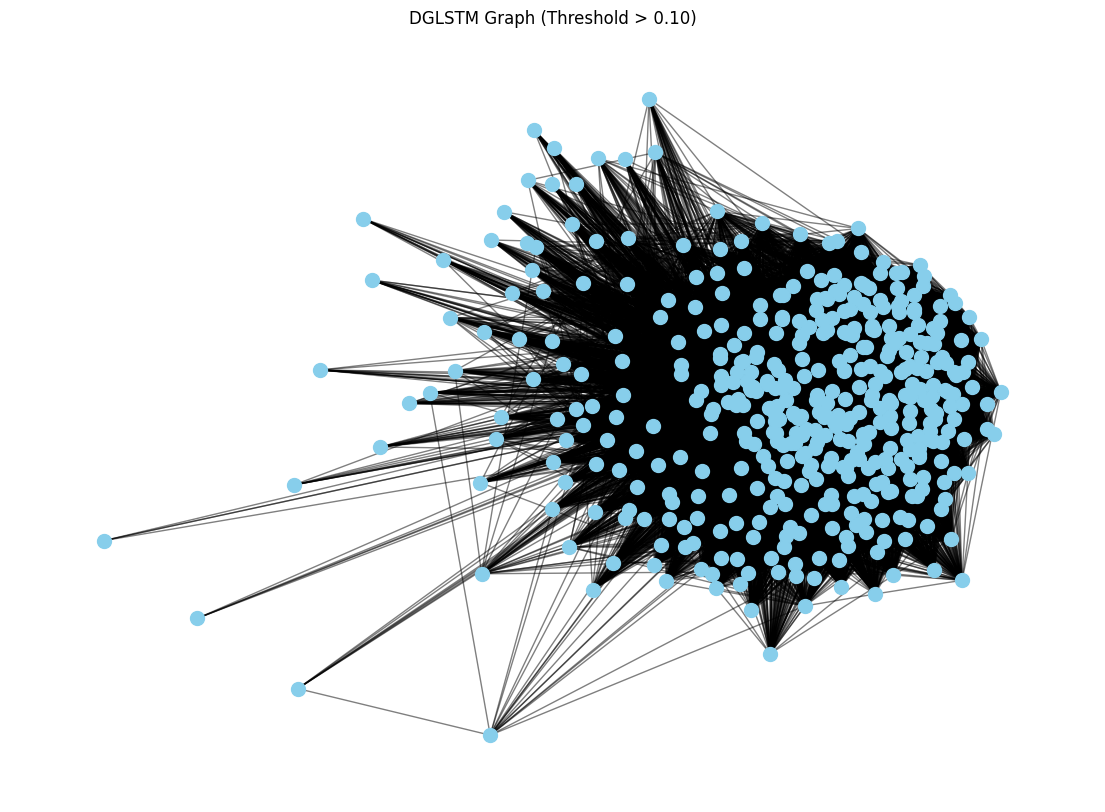

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# === 📥 Load matrix and tickers ===
graph_file = "/content/drive/MyDrive/take3/eachday/dglstm_by_day/dglstm_2025-03-22.npy"
tickers_file = "/content/drive/MyDrive/take3/eachday/valid_tickers.csv"

adj_matrix = np.load(graph_file)
tickers = pd.read_csv(tickers_file)["Symbol"].tolist()

# === 🧠 Build the graph ===
G = nx.Graph()

# Add nodes with labels
for i, ticker in enumerate(tickers):
    G.add_node(i, label=ticker)

# Add edges with weight > threshold
threshold = 0.1  # tweak if graph too dense/sparse
N = adj_matrix.shape[0]
for i in range(N):
    for j in range(i+1, N):  # upper triangle to avoid duplicate edges
        weight = adj_matrix[i, j]
        if weight > threshold:
            G.add_edge(i, j, weight=weight)

# === 🎨 Draw the graph ===
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)  # layout for positioning

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=100, node_color="skyblue")

# Draw edges
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=[(u, v) for u, v, w in edges], alpha=0.5)

# Optional: Draw node labels (could clutter with many stocks)
if len(tickers) <= 50:
    labels = {i: tickers[i] for i in range(len(tickers))}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("DGLSTM Graph (Threshold > {:.2f})".format(threshold))
plt.axis("off")
plt.show()


In [ ]:
import pandas as pd

# Try one of the skipped files
sample_file = "/content/drive/MyDrive/take3/eachday/stock_data/test/JUSTDIAL_test.csv"
df = pd.read_csv(sample_file)
print("Columns in the file:", df.columns.tolist())
print(df.head())


Columns in the file: ['Date', 'Close', 'Label', 'Return', 'nor_Close']
         Date       Close  Label    Return  nor_Close
0  2025-01-13  899.299988      1  0.000000   1.001933
1  2025-01-14  901.500000      0  0.002446   1.057681
2  2025-01-15  893.049988      1 -0.009373   0.843559
3  2025-01-16  895.750000      1  0.003023   0.911977
4  2025-01-17  913.400024      1  0.019704   1.359226


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
import pickle
from tqdm import tqdm
from datetime import datetime

# Define constants
SEQ_LENGTH = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
drive_folder = "/content/drive/MyDrive/take3"
model_path = f"{drive_folder}/best_lstm_model.pth"
test_folder = f"{drive_folder}/eachday/stock_data/test"
output_path = f"{drive_folder}/eachday/lstm_embeddings.pkl"

# Load test data
def load_stock_data(folder_path):
    stock_data = {}
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            stock_symbol = file_name.replace('.csv', '')
            stock_df = pd.read_csv(os.path.join(folder_path, file_name))
            stock_data[stock_symbol] = stock_df
    return stock_data

test_data = load_stock_data(test_folder)

# Define model
class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        stock_price = self.fc(h_n[-1])
        return stock_price, h_n

    def get_embedding(self, x):
        with torch.no_grad():
            _, (h_n, _) = self.lstm(x)
            return h_n[-1]

# Load best model
model = StockLSTM().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Generate daily embeddings
def generate_daily_embeddings(stock_data, model, start_date, end_date, save_path):
    date_range = pd.date_range(start=start_date, end=end_date)
    daily_embeddings = {}

    for date in tqdm(date_range, desc="Generating LSTM daily embeddings"):
        date_str = date.strftime("%Y-%m-%d")
        date_only = date.date()
        daily_embeddings[date_str] = {}
        success_count = 0

        for ticker, df in stock_data.items():
            if 'Date' not in df.columns or 'nor_Close' not in df.columns:
                print(f"⚠️ Skipping {ticker} — missing required columns")
                continue

            # Convert and clean date column
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df = df.dropna(subset=['Date'])
            df = df.sort_values('Date')
            df['date_only'] = df['Date'].dt.date

            match_indices = df.index[df['date_only'] == date_only].tolist()
            if len(match_indices) == 0:
                continue

            current_idx = match_indices[0]
            if current_idx < SEQ_LENGTH:
                continue

            window = df.iloc[current_idx - SEQ_LENGTH:current_idx]['nor_Close'].values

            if len(window) < SEQ_LENGTH:
                print("3")
                continue

            x = torch.tensor(window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            embedding = model.get_embedding(x).squeeze().cpu().numpy()

            daily_embeddings[date_str][ticker] = embedding
            success_count += 1

        if success_count == 0:
            print(f"🟡 No embeddings generated for {date_str}")

    with open(save_path, 'wb') as f:
        pickle.dump(daily_embeddings, f)

    print(f"✅ Saved extended embeddings to: {save_path}")

# Run it
generate_daily_embeddings(
    stock_data=test_data,
    model=model,
    start_date="2025-01-11",
    end_date="2025-03-22",
    save_path=output_path
)


Generating LSTM daily embeddings:   1%|▏         | 1/71 [00:01<01:20,  1.15s/it]

🟡 No embeddings generated for 2025-01-11


Generating LSTM daily embeddings:   3%|▎         | 2/71 [00:02<01:12,  1.05s/it]

🟡 No embeddings generated for 2025-01-12


Generating LSTM daily embeddings:  11%|█▏        | 8/71 [00:11<01:36,  1.53s/it]

🟡 No embeddings generated for 2025-01-18


Generating LSTM daily embeddings:  13%|█▎        | 9/71 [00:12<01:24,  1.36s/it]

🟡 No embeddings generated for 2025-01-19


Generating LSTM daily embeddings:  21%|██        | 15/71 [00:21<01:18,  1.40s/it]

🟡 No embeddings generated for 2025-01-25


Generating LSTM daily embeddings:  23%|██▎       | 16/71 [00:22<01:14,  1.36s/it]

🟡 No embeddings generated for 2025-01-26


Generating LSTM daily embeddings:  32%|███▏      | 23/71 [00:32<01:00,  1.25s/it]

🟡 No embeddings generated for 2025-02-02


Generating LSTM daily embeddings:  41%|████      | 29/71 [00:41<00:56,  1.33s/it]

🟡 No embeddings generated for 2025-02-08


Generating LSTM daily embeddings:  42%|████▏     | 30/71 [00:42<00:50,  1.22s/it]

🟡 No embeddings generated for 2025-02-09


Generating LSTM daily embeddings:  51%|█████     | 36/71 [00:51<00:52,  1.51s/it]

🟡 No embeddings generated for 2025-02-15


Generating LSTM daily embeddings:  52%|█████▏    | 37/71 [00:53<00:47,  1.41s/it]

🟡 No embeddings generated for 2025-02-16


Generating LSTM daily embeddings:  61%|██████    | 43/71 [01:00<00:33,  1.20s/it]

🟡 No embeddings generated for 2025-02-22


Generating LSTM daily embeddings:  62%|██████▏   | 44/71 [01:01<00:30,  1.12s/it]

🟡 No embeddings generated for 2025-02-23


Generating LSTM daily embeddings:  66%|██████▌   | 47/71 [01:06<00:36,  1.51s/it]

🟡 No embeddings generated for 2025-02-26


Generating LSTM daily embeddings:  70%|███████   | 50/71 [01:10<00:29,  1.38s/it]

🟡 No embeddings generated for 2025-03-01


Generating LSTM daily embeddings:  72%|███████▏  | 51/71 [01:11<00:25,  1.25s/it]

🟡 No embeddings generated for 2025-03-02


Generating LSTM daily embeddings:  80%|████████  | 57/71 [01:21<00:23,  1.69s/it]

🟡 No embeddings generated for 2025-03-08


Generating LSTM daily embeddings:  82%|████████▏ | 58/71 [01:22<00:19,  1.49s/it]

🟡 No embeddings generated for 2025-03-09


Generating LSTM daily embeddings:  89%|████████▊ | 63/71 [01:29<00:10,  1.33s/it]

🟡 No embeddings generated for 2025-03-14


Generating LSTM daily embeddings:  90%|█████████ | 64/71 [01:30<00:09,  1.30s/it]

🟡 No embeddings generated for 2025-03-15


Generating LSTM daily embeddings:  92%|█████████▏| 65/71 [01:31<00:07,  1.19s/it]

🟡 No embeddings generated for 2025-03-16


Generating LSTM daily embeddings: 100%|██████████| 71/71 [01:40<00:00,  1.41s/it]

🟡 No embeddings generated for 2025-03-22


✅ Saved extended embeddings to: /content/drive/MyDrive/take3/eachday/lstm_embeddings.pkl


In [ ]:
import pickle

embedding_path = "/content/drive/MyDrive/take3/eachday/lstm_embeddings.pkl"

with open(embedding_path, "rb") as f:
    data = pickle.load(f)

print(f"✅ Loaded embeddings for {len(data)} dates.")
for i, (date, stock_dict) in enumerate(data.items()):
    print(f"{date}: {len(stock_dict)} tickers")
    if i == 71:  # Just preview first 3 dates
        break



In [ ]:
!pip install -q torch torchvision torchaudio torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.3 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torch.nn as nn
import pickle
import numpy as np
import pandas as pd
from torch_geometric.nn import GATConv
from tqdm import tqdm
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
drive_path = "/content/drive/MyDrive/take3"
embedding_path = f"{drive_path}/eachday/lstm_embeddings.pkl"
graph_template = f"{drive_path}/eachday/dglstm_by_day/dglstm_{{}}.npy"  # Updated for the new format
label_template = f"{drive_path}/eachday/stock_data/test/{{}}.csv"  # Updated for the correct format
enhanced_save_path = f"{drive_path}/eachday/enhanced_daily"
ranking_save_path = f"{drive_path}/eachday/predicted_rankings"
os.makedirs(enhanced_save_path, exist_ok=True)
os.makedirs(ranking_save_path, exist_ok=True)

# GAT model definition
class GATPredictor(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=64, heads=4):
        super(GATPredictor, self).__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=heads, dropout=0.4)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.4)
        self.fc = nn.Linear(hidden_dim * heads, 1)

    def forward(self, x, edge_index, edge_weight):
        x = self.gat1(x, edge_index, edge_weight)
        x = self.gat2(x, edge_index, edge_weight)
        enhanced = x.clone()
        out = self.fc(enhanced).squeeze()
        return out, enhanced

# Load all daily embeddings
with open(embedding_path, "rb") as f:
    all_embeddings = pickle.load(f)

date_list = sorted(all_embeddings.keys())

# Load per-day data
def load_day_data(date_str, day_idx):
    embeddings = all_embeddings.get(date_str, {})
    if len(embeddings) == 0:
        raise ValueError(f"No embeddings found for date {date_str}")

    stock_list = sorted(embeddings.keys())
    features = np.stack([embeddings[s] for s in stock_list])
    features = features / np.clip(np.linalg.norm(features, axis=1, keepdims=True), 1e-8, None)
    x = torch.tensor(features, dtype=torch.float).to(device)

    # Load graph
    graph_file = graph_template.format(date_str)  # Correct format
    adj = np.load(graph_file)
    edge_index, edge_weight = [], []
    for i in range(len(stock_list)):
        for j in range(len(stock_list)):
            if adj[i, j] != 0:
                edge_index.append([i, j])
                edge_weight.append(adj[i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous().to(device)
    edge_weight = torch.tensor(edge_weight, dtype=torch.float).to(device)

    # Load labels and returns from {company_name}_test.csv
    labels, returns = [], []
    for stock in tqdm(stock_list):
        try:
            df = pd.read_csv(label_template.format(stock))  # Corrected for {company_name}_test.csv
            df['Date'] = pd.to_datetime(df['Date'])
            row = df[df['Date'] == date_str]
            if row.empty:
                labels.append(0)
                returns.append(0.0)
                print(f"🔴 No data for stock {stock} on {date_str}. Assigning label=0 and return=0.0.")
            else:
                labels.append(int(row["Label"].values[0]))
                return_value = float(row["Return"].values[0])
                returns.append(return_value)
        except Exception as e:
            labels.append(0)
            returns.append(0.0)
            print(f"❌ Error loading data for stock {stock} on {date_str}: {e}")

    y = torch.tensor(labels, dtype=torch.long)

    return x, edge_index, edge_weight, y.numpy(), np.array(returns), stock_list

# Evaluation logic
def evaluate_day(pred_scores, true_labels, return_ratios, stock_list, date_str, k_values=[5, 10, 15, 20]):
    print(f"\n📅 {date_str} Evaluation")
    pred_rank = np.argsort(-pred_scores)
    true_return_rank = np.argsort(-return_ratios)
    stock_to_pred_rank = {stock_list[idx]: rank + 1 for rank, idx in enumerate(pred_rank)}
    stock_to_return_rank = {stock_list[idx]: rank + 1 for rank, idx in enumerate(true_return_rank)}

    result = {}
    for k in k_values:
        topk_pred_idx = pred_rank[:k]
        topk_true_idx = true_return_rank[:k]
        topk_true_stocks = [stock_list[i] for i in topk_true_idx]
        topk_pred_stocks = [stock_list[i] for i in topk_pred_idx]

        precision = len(set(topk_pred_stocks) & set(topk_true_stocks)) / k
        mrr = np.sum([1 / stock_to_pred_rank[stock] for stock in topk_true_stocks]) / k
        irr = np.sum(return_ratios[topk_pred_idx]) - np.sum(pred_scores[topk_pred_idx])
        mae = np.mean(np.abs(pred_scores[topk_pred_idx] - return_ratios[topk_pred_idx]))

        result[k] = {
            "precision": precision,
            "mrr": mrr,
            "irr": irr,
            "mae": mae
        }

        print(f"Top-{k}: Precision={precision:.4f}, MRR={mrr:.4f}, IRR={irr:.4f}, MAE={mae:.4f}")

    return result

# Full run loop
def run_daily_predictions():
    model = GATPredictor().to(device)
    model.load_state_dict(torch.load(f"{drive_path}/gat_best_model.pth", map_location=device))  # Load the best GAT model
    model.eval()

    all_results = {}
    all_predictions = []  # To collect all predictions for final CSV
    total_metrics = {5: {'precision': 0, 'mrr': 0, 'irr': 0, 'mae': 0},
                     10: {'precision': 0, 'mrr': 0, 'irr': 0, 'mae': 0},
                     15: {'precision': 0, 'mrr': 0, 'irr': 0, 'mae': 0},
                     20: {'precision': 0, 'mrr': 0, 'irr': 0, 'mae': 0}}  # For averaging

    for day_idx, date_str in enumerate(tqdm(date_list, desc="Predicting each day")):
        try:
            x, ei, ew, y, returns, stock_list = load_day_data(date_str, day_idx)
            with torch.no_grad():
                preds, enhanced = model(x, ei, ew)
                preds=preds/10
            np.save(f"{enhanced_save_path}/embedding_day{day_idx}.npy", enhanced.cpu().numpy())
            results = evaluate_day(preds.cpu().numpy(), y, returns, stock_list, date_str)

            # Save daily rankings to CSV
            ranking_df = pd.DataFrame({
                "stock": stock_list,
                "predicted_return": preds.cpu().numpy(),
                "actual_return": returns
            })
            ranking_df = ranking_df.sort_values(by="predicted_return", ascending=False).reset_index(drop=True)
            ranking_df.to_csv(f"{ranking_save_path}/ranking_{date_str}.csv", index=False)

            # Collect results for final CSV
            all_predictions.append(ranking_df)

            # Update total metrics for averaging
            for k in [5, 10, 15, 20]:
                total_metrics[k]['precision'] += results[k]['precision']
                total_metrics[k]['mrr'] += results[k]['mrr']
                total_metrics[k]['irr'] += results[k]['irr']
                total_metrics[k]['mae'] += results[k]['mae']

            all_results[date_str] = results
        except FileNotFoundError as e:
            print(f"❌ Skipping {date_str} due to missing file: {e}")
            continue
        except Exception as e:
            print(f"❌ Error on {date_str}: {e}")
            continue

    # Save all predictions to one CSV
    all_predictions_df = pd.concat(all_predictions, ignore_index=True)
    all_predictions_df.to_csv(f"{ranking_save_path}/all_predictions.csv", index=False)

    # Calculate final metrics as averages
    num_days = len(date_list)
    print("\n📊 Final Metrics (averaged over all days):")
    for k in [5, 10, 15, 20]:
        avg_precision = total_metrics[k]['precision'] / num_days
        avg_mrr = total_metrics[k]['mrr'] / num_days
        avg_irr = total_metrics[k]['irr'] / num_days
        avg_mae = total_metrics[k]['mae'] / num_days
        print(f"Top-{k}: Precision={avg_precision:.4f}, MRR={avg_mrr:.4f}, IRR={avg_irr:.4f}, MAE={avg_mae:.4f}")
    return all_results

# Run
if __name__ == "__main__":
    daily_metrics = run_daily_predictions()


Predicting each day:   0%|          | 0/71 [00:00<?, ?it/s]

❌ Error on 2025-01-11: No embeddings found for date 2025-01-11
❌ Error on 2025-01-12: No embeddings found for date 2025-01-12
❌ Skipping 2025-01-13 due to missing file: [Errno 2] No such file or directory: '/content/drive/MyDrive/take3/eachday/dglstm_by_day/dglstm_2025-01-13.npy'
❌ Skipping 2025-01-14 due to missing file: [Errno 2] No such file or directory: '/content/drive/MyDrive/take3/eachday/dglstm_by_day/dglstm_2025-01-14.npy'



Predicting each day:   7%|▋         | 5/71 [00:29<06:23,  5.81s/it]


📅 2025-01-15 Evaluation
Top-5: Precision=0.0000, MRR=0.0073, IRR=-0.0897, MAE=0.0189
Top-10: Precision=0.0000, MRR=0.0056, IRR=-0.0951, MAE=0.0127
Top-15: Precision=0.0000, MRR=0.0052, IRR=-0.0851, MAE=0.0096
Top-20: Precision=0.0000, MRR=0.0058, IRR=-0.1012, MAE=0.0105



100%|██████████| 445/445 [00:03<00:00, 129.97it/s]



📅 2025-01-16 Evaluation
Top-5: Precision=0.2000, MRR=0.1026, IRR=0.0960, MAE=0.0248
Top-10: Precision=0.1000, MRR=0.0553, IRR=0.0609, MAE=0.0176
Top-15: Precision=0.0667, MRR=0.0413, IRR=0.0740, MAE=0.0162
Top-20: Precision=0.0500, MRR=0.0330, IRR=0.0959, MAE=0.0139


Predicting each day:  10%|▉         | 7/71 [00:39<05:48,  5.44s/it]


📅 2025-01-17 Evaluation
Top-5: Precision=0.0000, MRR=0.0040, IRR=-0.0646, MAE=0.0135
Top-10: Precision=0.0000, MRR=0.0048, IRR=-0.2011, MAE=0.0223
Top-15: Precision=0.0000, MRR=0.0059, IRR=-0.2148, MAE=0.0166
Top-20: Precision=0.0000, MRR=0.0053, IRR=-0.2498, MAE=0.0150
❌ Error on 2025-01-18: No embeddings found for date 2025-01-18
❌ Error on 2025-01-19: No embeddings found for date 2025-01-19



Predicting each day:  14%|█▍        | 10/71 [00:44<03:36,  3.55s/it]


📅 2025-01-20 Evaluation
Top-5: Precision=0.0000, MRR=0.0188, IRR=-0.0469, MAE=0.0137
Top-10: Precision=0.0000, MRR=0.0153, IRR=-0.0198, MAE=0.0112
Top-15: Precision=0.0000, MRR=0.0128, IRR=-0.0735, MAE=0.0137
Top-20: Precision=0.0000, MRR=0.0112, IRR=-0.0663, MAE=0.0128



100%|██████████| 445/445 [00:03<00:00, 130.48it/s]



📅 2025-01-21 Evaluation
Top-5: Precision=0.2000, MRR=0.0574, IRR=-0.1526, MAE=0.0334
Top-10: Precision=0.1000, MRR=0.0310, IRR=-0.2498, MAE=0.0264
Top-15: Precision=0.1333, MRR=0.0239, IRR=-0.2451, MAE=0.0206
Top-20: Precision=0.1000, MRR=0.0210, IRR=-0.3023, MAE=0.0183


100%|██████████| 445/445 [00:03<00:00, 143.58it/s]



📅 2025-01-22 Evaluation
Top-5: Precision=0.0000, MRR=0.0031, IRR=-0.1412, MAE=0.0282
Top-10: Precision=0.0000, MRR=0.0036, IRR=-0.2150, MAE=0.0236
Top-15: Precision=0.0000, MRR=0.0045, IRR=-0.3612, MAE=0.0255
Top-20: Precision=0.0000, MRR=0.0049, IRR=-0.3475, MAE=0.0217


100%|██████████| 445/445 [00:03<00:00, 127.33it/s]



📅 2025-01-23 Evaluation
Top-5: Precision=0.0000, MRR=0.0050, IRR=-0.1056, MAE=0.0211
Top-10: Precision=0.0000, MRR=0.0086, IRR=-0.1120, MAE=0.0198
Top-15: Precision=0.0000, MRR=0.0090, IRR=-0.0767, MAE=0.0188
Top-20: Precision=0.0000, MRR=0.0090, IRR=-0.1046, MAE=0.0172


Predicting each day:  20%|█▉        | 14/71 [01:04<04:20,  4.56s/it]


📅 2025-01-24 Evaluation
Top-5: Precision=0.0000, MRR=0.0086, IRR=-0.1953, MAE=0.0391
Top-10: Precision=0.0000, MRR=0.0098, IRR=-0.3129, MAE=0.0313
Top-15: Precision=0.0000, MRR=0.0133, IRR=-0.4507, MAE=0.0309
Top-20: Precision=0.1000, MRR=0.0153, IRR=-0.4867, MAE=0.0269
❌ Error on 2025-01-25: No embeddings found for date 2025-01-25
❌ Error on 2025-01-26: No embeddings found for date 2025-01-26



100%|██████████| 445/445 [00:03<00:00, 137.50it/s]



📅 2025-01-27 Evaluation
Top-5: Precision=0.0000, MRR=0.0122, IRR=-0.2339, MAE=0.0468
Top-10: Precision=0.0000, MRR=0.0171, IRR=-0.4339, MAE=0.0434
Top-15: Precision=0.0667, MRR=0.0455, IRR=-0.6588, MAE=0.0439
Top-20: Precision=0.0500, MRR=0.0365, IRR=-0.8756, MAE=0.0438


100%|██████████| 445/445 [00:03<00:00, 124.33it/s]



📅 2025-01-28 Evaluation
Top-5: Precision=0.0000, MRR=0.0165, IRR=-0.1832, MAE=0.0368
Top-10: Precision=0.0000, MRR=0.0181, IRR=-0.3830, MAE=0.0384
Top-15: Precision=0.0667, MRR=0.0174, IRR=-0.3900, MAE=0.0327
Top-20: Precision=0.1000, MRR=0.0150, IRR=-0.4594, MAE=0.0321


Predicting each day:  27%|██▋       | 19/71 [01:20<03:21,  3.88s/it]


📅 2025-01-29 Evaluation
Top-5: Precision=0.0000, MRR=0.0047, IRR=-0.0700, MAE=0.0183
Top-10: Precision=0.0000, MRR=0.0042, IRR=-0.0034, MAE=0.0196
Top-15: Precision=0.0667, MRR=0.0094, IRR=0.0194, MAE=0.0235
Top-20: Precision=0.0500, MRR=0.0090, IRR=0.1487, MAE=0.0241



100%|██████████| 445/445 [00:03<00:00, 135.06it/s]



📅 2025-01-30 Evaluation
Top-5: Precision=0.0000, MRR=0.0093, IRR=-0.0665, MAE=0.0173
Top-10: Precision=0.0000, MRR=0.0066, IRR=-0.1442, MAE=0.0164
Top-15: Precision=0.0000, MRR=0.0080, IRR=-0.5024, MAE=0.0357
Top-20: Precision=0.0000, MRR=0.0085, IRR=-0.5812, MAE=0.0307


Predicting each day:  30%|██▉       | 21/71 [01:30<03:45,  4.51s/it]


📅 2025-01-31 Evaluation
Top-5: Precision=0.0000, MRR=0.0046, IRR=0.0169, MAE=0.0115
Top-10: Precision=0.0000, MRR=0.0064, IRR=0.0186, MAE=0.0115
Top-15: Precision=0.0000, MRR=0.0056, IRR=-0.0439, MAE=0.0180
Top-20: Precision=0.0000, MRR=0.0061, IRR=0.0198, MAE=0.0167



100%|██████████| 445/445 [00:03<00:00, 134.42it/s]



📅 2025-02-01 Evaluation
Top-5: Precision=0.0000, MRR=0.0036, IRR=-0.0054, MAE=0.0155
Top-10: Precision=0.1000, MRR=0.0148, IRR=-0.0293, MAE=0.0253
Top-15: Precision=0.0667, MRR=0.0116, IRR=-0.1756, MAE=0.0297
Top-20: Precision=0.0500, MRR=0.0112, IRR=-0.2114, MAE=0.0284


Predicting each day:  31%|███       | 22/71 [01:35<03:47,  4.63s/it]

❌ Error on 2025-02-02: No embeddings found for date 2025-02-02



Predicting each day:  34%|███▍      | 24/71 [01:41<03:04,  3.93s/it]


📅 2025-02-03 Evaluation
Top-5: Precision=0.0000, MRR=0.0050, IRR=-0.2378, MAE=0.0476
Top-10: Precision=0.0000, MRR=0.0037, IRR=-0.4659, MAE=0.0466
Top-15: Precision=0.0000, MRR=0.0037, IRR=-0.6517, MAE=0.0442
Top-20: Precision=0.0000, MRR=0.0044, IRR=-0.7705, MAE=0.0402



100%|██████████| 445/445 [00:03<00:00, 142.46it/s]



📅 2025-02-04 Evaluation
Top-5: Precision=0.0000, MRR=0.0034, IRR=-0.0805, MAE=0.0170
Top-10: Precision=0.0000, MRR=0.0051, IRR=-0.0792, MAE=0.0130
Top-15: Precision=0.0000, MRR=0.0052, IRR=-0.0424, MAE=0.0148
Top-20: Precision=0.0000, MRR=0.0052, IRR=-0.0459, MAE=0.0142


100%|██████████| 445/445 [00:03<00:00, 134.32it/s]



📅 2025-02-05 Evaluation
Top-5: Precision=0.0000, MRR=0.0252, IRR=-0.0530, MAE=0.0137
Top-10: Precision=0.0000, MRR=0.0153, IRR=-0.0698, MAE=0.0189
Top-15: Precision=0.1333, MRR=0.0197, IRR=0.0008, MAE=0.0189
Top-20: Precision=0.1000, MRR=0.0167, IRR=-0.0354, MAE=0.0163


100%|██████████| 445/445 [00:03<00:00, 128.83it/s]



📅 2025-02-06 Evaluation
Top-5: Precision=0.0000, MRR=0.0096, IRR=-0.1279, MAE=0.0256
Top-10: Precision=0.0000, MRR=0.0082, IRR=-0.2789, MAE=0.0279
Top-15: Precision=0.0000, MRR=0.0082, IRR=-0.2970, MAE=0.0230
Top-20: Precision=0.0000, MRR=0.0072, IRR=-0.3932, MAE=0.0236


Predicting each day:  39%|███▉      | 28/71 [02:02<03:31,  4.91s/it]


📅 2025-02-07 Evaluation
Top-5: Precision=0.0000, MRR=0.0052, IRR=-0.0587, MAE=0.0199
Top-10: Precision=0.1000, MRR=0.1052, IRR=-0.1712, MAE=0.0212
Top-15: Precision=0.0667, MRR=0.0714, IRR=-0.2722, MAE=0.0209
Top-20: Precision=0.0500, MRR=0.0543, IRR=-0.3110, MAE=0.0179
❌ Error on 2025-02-08: No embeddings found for date 2025-02-08
❌ Error on 2025-02-09: No embeddings found for date 2025-02-09



100%|██████████| 445/445 [00:03<00:00, 127.08it/s]



📅 2025-02-10 Evaluation
Top-5: Precision=0.0000, MRR=0.0071, IRR=-0.2325, MAE=0.0465
Top-10: Precision=0.0000, MRR=0.0085, IRR=-0.4560, MAE=0.0456
Top-15: Precision=0.0000, MRR=0.0086, IRR=-0.6337, MAE=0.0422
Top-20: Precision=0.0000, MRR=0.0086, IRR=-0.7269, MAE=0.0363


Predicting each day:  45%|████▌     | 32/71 [02:13<02:20,  3.61s/it]


📅 2025-02-11 Evaluation
Top-5: Precision=0.0000, MRR=0.0060, IRR=-0.3053, MAE=0.0611
Top-10: Precision=0.1000, MRR=0.0149, IRR=-0.5130, MAE=0.0516
Top-15: Precision=0.0667, MRR=0.0123, IRR=-0.7178, MAE=0.0481
Top-20: Precision=0.0500, MRR=0.0126, IRR=-0.8956, MAE=0.0449



Predicting each day:  46%|████▋     | 33/71 [02:18<02:26,  3.86s/it]


📅 2025-02-12 Evaluation
Top-5: Precision=0.0000, MRR=0.0066, IRR=-0.1980, MAE=0.0396
Top-10: Precision=0.0000, MRR=0.0084, IRR=-0.3143, MAE=0.0314
Top-15: Precision=0.0000, MRR=0.0069, IRR=-0.4814, MAE=0.0321
Top-20: Precision=0.0000, MRR=0.0060, IRR=-0.6504, MAE=0.0325



100%|██████████| 445/445 [00:03<00:00, 112.63it/s]



📅 2025-02-13 Evaluation
Top-5: Precision=0.0000, MRR=0.0027, IRR=-0.1362, MAE=0.0272
Top-10: Precision=0.0000, MRR=0.0041, IRR=-0.2254, MAE=0.0235
Top-15: Precision=0.0000, MRR=0.0079, IRR=-0.3792, MAE=0.0260
Top-20: Precision=0.0000, MRR=0.0073, IRR=-0.4602, MAE=0.0236


100%|██████████| 445/445 [00:03<00:00, 143.36it/s]



📅 2025-02-14 Evaluation
Top-5: Precision=0.0000, MRR=0.0062, IRR=-0.2743, MAE=0.0549
Top-10: Precision=0.0000, MRR=0.0047, IRR=-0.5086, MAE=0.0509
Top-15: Precision=0.0000, MRR=0.0073, IRR=-0.7203, MAE=0.0480
Top-20: Precision=0.0000, MRR=0.0071, IRR=-0.9267, MAE=0.0463


Predicting each day:  49%|████▉     | 35/71 [02:29<02:42,  4.52s/it]

❌ Error on 2025-02-15: No embeddings found for date 2025-02-15
❌ Error on 2025-02-16: No embeddings found for date 2025-02-16



100%|██████████| 445/445 [00:03<00:00, 139.03it/s]



📅 2025-02-17 Evaluation
Top-5: Precision=0.0000, MRR=0.0057, IRR=-0.1125, MAE=0.0225
Top-10: Precision=0.0000, MRR=0.0057, IRR=-0.2113, MAE=0.0211
Top-15: Precision=0.0000, MRR=0.0053, IRR=-0.2008, MAE=0.0170
Top-20: Precision=0.0000, MRR=0.0053, IRR=-0.3250, MAE=0.0198


100%|██████████| 445/445 [00:05<00:00, 84.47it/s] 



📅 2025-02-18 Evaluation
Top-5: Precision=0.0000, MRR=0.0060, IRR=-0.0439, MAE=0.0140
Top-10: Precision=0.0000, MRR=0.0053, IRR=-0.2398, MAE=0.0266
Top-15: Precision=0.0667, MRR=0.0377, IRR=-0.4134, MAE=0.0293
Top-20: Precision=0.0500, MRR=0.0294, IRR=-0.5787, MAE=0.0302


100%|██████████| 445/445 [00:02<00:00, 148.97it/s]



📅 2025-02-19 Evaluation
Top-5: Precision=0.0000, MRR=0.0170, IRR=-0.0422, MAE=0.0175
Top-10: Precision=0.0000, MRR=0.0114, IRR=-0.0646, MAE=0.0148
Top-15: Precision=0.0667, MRR=0.0134, IRR=0.0409, MAE=0.0169
Top-20: Precision=0.0500, MRR=0.0111, IRR=0.1235, MAE=0.0216


Predicting each day:  58%|█████▊    | 41/71 [02:51<02:11,  4.40s/it]


📅 2025-02-20 Evaluation
Top-5: Precision=0.0000, MRR=0.0085, IRR=-0.0313, MAE=0.0125
Top-10: Precision=0.1000, MRR=0.0293, IRR=0.0160, MAE=0.0140
Top-15: Precision=0.0667, MRR=0.0206, IRR=-0.0727, MAE=0.0166
Top-20: Precision=0.0500, MRR=0.0182, IRR=-0.0923, MAE=0.0152



Predicting each day:  59%|█████▉    | 42/71 [02:56<02:10,  4.49s/it]


📅 2025-02-21 Evaluation
Top-5: Precision=0.0000, MRR=0.0046, IRR=-0.1352, MAE=0.0270
Top-10: Precision=0.0000, MRR=0.0046, IRR=-0.3115, MAE=0.0312
Top-15: Precision=0.0000, MRR=0.0044, IRR=-0.4244, MAE=0.0283
Top-20: Precision=0.0000, MRR=0.0079, IRR=-0.5365, MAE=0.0268
❌ Error on 2025-02-22: No embeddings found for date 2025-02-22
❌ Error on 2025-02-23: No embeddings found for date 2025-02-23



Predicting each day:  63%|██████▎   | 45/71 [03:00<01:16,  2.96s/it]


📅 2025-02-24 Evaluation
Top-5: Precision=0.0000, MRR=0.0074, IRR=-0.1639, MAE=0.0328
Top-10: Precision=0.0000, MRR=0.0079, IRR=-0.3252, MAE=0.0325
Top-15: Precision=0.0000, MRR=0.0075, IRR=-0.4781, MAE=0.0319
Top-20: Precision=0.0000, MRR=0.0067, IRR=-0.6370, MAE=0.0319



Predicting each day:  65%|██████▍   | 46/71 [03:10<01:44,  4.19s/it]


📅 2025-02-25 Evaluation
Top-5: Precision=0.0000, MRR=0.0121, IRR=-0.1089, MAE=0.0287
Top-10: Precision=0.0000, MRR=0.0076, IRR=-0.2107, MAE=0.0245
Top-15: Precision=0.0667, MRR=0.0195, IRR=-0.3352, MAE=0.0246
Top-20: Precision=0.0500, MRR=0.0154, IRR=-0.4382, MAE=0.0236
❌ Error on 2025-02-26: No embeddings found for date 2025-02-26



100%|██████████| 445/445 [00:03<00:00, 126.41it/s]



📅 2025-02-27 Evaluation
Top-5: Precision=0.0000, MRR=0.0143, IRR=-0.1926, MAE=0.0385
Top-10: Precision=0.0000, MRR=0.0094, IRR=-0.3358, MAE=0.0336
Top-15: Precision=0.0000, MRR=0.0108, IRR=-0.5410, MAE=0.0361
Top-20: Precision=0.1000, MRR=0.0090, IRR=-0.5892, MAE=0.0366


Predicting each day:  69%|██████▉   | 49/71 [03:21<01:28,  4.03s/it]


📅 2025-02-28 Evaluation
Top-5: Precision=0.0000, MRR=0.0058, IRR=-0.2873, MAE=0.0575
Top-10: Precision=0.0000, MRR=0.0083, IRR=-0.5776, MAE=0.0578
Top-15: Precision=0.0000, MRR=0.0107, IRR=-0.8385, MAE=0.0559
Top-20: Precision=0.1000, MRR=0.0151, IRR=-0.9194, MAE=0.0472
❌ Error on 2025-03-01: No embeddings found for date 2025-03-01
❌ Error on 2025-03-02: No embeddings found for date 2025-03-02



100%|██████████| 445/445 [00:02<00:00, 148.39it/s]



📅 2025-03-03 Evaluation
Top-5: Precision=0.0000, MRR=0.0035, IRR=-0.1665, MAE=0.0333
Top-10: Precision=0.0000, MRR=0.0049, IRR=-0.3157, MAE=0.0316
Top-15: Precision=0.0000, MRR=0.0047, IRR=-0.4963, MAE=0.0334
Top-20: Precision=0.0000, MRR=0.0046, IRR=-0.5993, MAE=0.0302


100%|██████████| 445/445 [00:03<00:00, 144.37it/s]



📅 2025-03-04 Evaluation
Top-5: Precision=0.0000, MRR=0.0311, IRR=-0.0879, MAE=0.0212
Top-10: Precision=0.1000, MRR=0.0175, IRR=0.0163, MAE=0.0314
Top-15: Precision=0.0667, MRR=0.0127, IRR=-0.0428, MAE=0.0251
Top-20: Precision=0.1000, MRR=0.0165, IRR=-0.1083, MAE=0.0227


Predicting each day:  76%|███████▌  | 54/71 [03:36<01:03,  3.73s/it]


📅 2025-03-05 Evaluation
Top-5: Precision=0.0000, MRR=0.0146, IRR=-0.0309, MAE=0.0183
Top-10: Precision=0.0000, MRR=0.0093, IRR=0.0715, MAE=0.0206
Top-15: Precision=0.0000, MRR=0.0080, IRR=0.0784, MAE=0.0167
Top-20: Precision=0.0500, MRR=0.0078, IRR=0.1936, MAE=0.0202



100%|██████████| 445/445 [00:03<00:00, 145.27it/s]



📅 2025-03-06 Evaluation
Top-5: Precision=0.2000, MRR=0.2023, IRR=0.0792, MAE=0.0279
Top-10: Precision=0.1000, MRR=0.1098, IRR=0.0236, MAE=0.0208
Top-15: Precision=0.0667, MRR=0.0758, IRR=0.0280, MAE=0.0173
Top-20: Precision=0.1000, MRR=0.0597, IRR=0.0857, MAE=0.0165


100%|██████████| 445/445 [00:02<00:00, 149.52it/s]



📅 2025-03-07 Evaluation
Top-5: Precision=0.0000, MRR=0.0184, IRR=-0.0857, MAE=0.0208
Top-10: Precision=0.0000, MRR=0.0124, IRR=-0.1032, MAE=0.0228
Top-15: Precision=0.1333, MRR=0.0172, IRR=-0.1163, MAE=0.0247
Top-20: Precision=0.1000, MRR=0.0141, IRR=-0.2319, MAE=0.0243


Predicting each day:  79%|███████▉  | 56/71 [03:45<01:02,  4.17s/it]

❌ Error on 2025-03-08: No embeddings found for date 2025-03-08
❌ Error on 2025-03-09: No embeddings found for date 2025-03-09



Predicting each day:  83%|████████▎ | 59/71 [03:51<00:36,  3.00s/it]


📅 2025-03-10 Evaluation
Top-5: Precision=0.2000, MRR=0.0489, IRR=-0.0999, MAE=0.0287
Top-10: Precision=0.2000, MRR=0.0513, IRR=-0.3397, MAE=0.0383
Top-15: Precision=0.1333, MRR=0.0366, IRR=-0.5447, MAE=0.0392
Top-20: Precision=0.1000, MRR=0.0286, IRR=-0.7238, MAE=0.0384



100%|██████████| 445/445 [00:03<00:00, 142.21it/s]



📅 2025-03-11 Evaluation
Top-5: Precision=0.0000, MRR=0.0104, IRR=-0.0789, MAE=0.0158
Top-10: Precision=0.0000, MRR=0.0072, IRR=-0.1874, MAE=0.0187
Top-15: Precision=0.0000, MRR=0.0063, IRR=-0.2951, MAE=0.0204
Top-20: Precision=0.0000, MRR=0.0060, IRR=-0.3993, MAE=0.0205


100%|██████████| 445/445 [00:03<00:00, 128.61it/s]



📅 2025-03-12 Evaluation
Top-5: Precision=0.0000, MRR=0.0042, IRR=-0.1163, MAE=0.0233
Top-10: Precision=0.0000, MRR=0.0036, IRR=-0.2337, MAE=0.0234
Top-15: Precision=0.0667, MRR=0.0117, IRR=-0.3247, MAE=0.0236
Top-20: Precision=0.0500, MRR=0.0112, IRR=-0.4577, MAE=0.0244


Predicting each day:  87%|████████▋ | 62/71 [04:06<00:36,  4.08s/it]


📅 2025-03-13 Evaluation
Top-5: Precision=0.0000, MRR=0.0214, IRR=-0.1306, MAE=0.0276
Top-10: Precision=0.0000, MRR=0.0168, IRR=-0.2699, MAE=0.0277
Top-15: Precision=0.0667, MRR=0.0143, IRR=-0.3193, MAE=0.0280
Top-20: Precision=0.0500, MRR=0.0114, IRR=-0.4538, MAE=0.0277
❌ Error on 2025-03-14: No embeddings found for date 2025-03-14
❌ Error on 2025-03-15: No embeddings found for date 2025-03-15
❌ Error on 2025-03-16: No embeddings found for date 2025-03-16



100%|██████████| 445/445 [00:03<00:00, 142.17it/s]



📅 2025-03-17 Evaluation
Top-5: Precision=0.0000, MRR=0.0183, IRR=-0.0940, MAE=0.0188
Top-10: Precision=0.0000, MRR=0.0125, IRR=-0.2601, MAE=0.0260
Top-15: Precision=0.0667, MRR=0.0094, IRR=-0.3263, MAE=0.0273
Top-20: Precision=0.0500, MRR=0.0085, IRR=-0.4606, MAE=0.0272


100%|██████████| 445/445 [00:03<00:00, 119.50it/s]



📅 2025-03-18 Evaluation
Top-5: Precision=0.0000, MRR=0.0197, IRR=-0.1009, MAE=0.0202
Top-10: Precision=0.0000, MRR=0.0122, IRR=-0.1950, MAE=0.0195
Top-15: Precision=0.0667, MRR=0.0112, IRR=-0.2848, MAE=0.0190
Top-20: Precision=0.0500, MRR=0.0099, IRR=-0.3690, MAE=0.0184


Predicting each day:  96%|█████████▌| 68/71 [04:22<00:10,  3.39s/it]


📅 2025-03-19 Evaluation
Top-5: Precision=0.0000, MRR=0.0111, IRR=0.0629, MAE=0.0230
Top-10: Precision=0.0000, MRR=0.0091, IRR=0.0571, MAE=0.0197
Top-15: Precision=0.0000, MRR=0.0074, IRR=0.2633, MAE=0.0269
Top-20: Precision=0.0500, MRR=0.0114, IRR=0.4488, MAE=0.0307



100%|██████████| 445/445 [00:03<00:00, 144.90it/s]



📅 2025-03-20 Evaluation
Top-5: Precision=0.0000, MRR=0.0259, IRR=-0.1130, MAE=0.0226
Top-10: Precision=0.0000, MRR=0.0145, IRR=-0.1668, MAE=0.0185
Top-15: Precision=0.0667, MRR=0.0117, IRR=-0.1242, MAE=0.0213
Top-20: Precision=0.0500, MRR=0.0098, IRR=-0.1226, MAE=0.0179


Predicting each day: 100%|██████████| 71/71 [04:32<00:00,  3.84s/it]


📅 2025-03-21 Evaluation
Top-5: Precision=0.2000, MRR=0.0737, IRR=0.0740, MAE=0.0307
Top-10: Precision=0.1000, MRR=0.0393, IRR=0.0670, MAE=0.0224
Top-15: Precision=0.1333, MRR=0.0306, IRR=0.2123, MAE=0.0308
Top-20: Precision=0.1000, MRR=0.0252, IRR=0.1892, MAE=0.0270
❌ Error on 2025-03-22: No embeddings found for date 2025-03-22



📊 Final Metrics (averaged over all days):
Top-5: Precision=0.0141, MRR=0.0130, IRR=-0.0698, MAE=0.0180
Top-10: Precision=0.0155, MRR=0.0111, IRR=-0.1310, MAE=0.0176
Top-15: Precision=0.0263, MRR=0.0106, IRR=-0.1822, MAE=0.0178
Top-20: Precision=0.0275, MRR=0.0094, IRR=-0.2217, MAE=0.0170


In [ ]:
# 📁 Define Paths
drive_path = "/content/drive/MyDrive/take3"
embedding_path = f"{drive_path}/eachday/lstm_embeddings.pkl"
graph_template = f"{drive_path}/eachday/dglstm_by_day/dglstm_{{}}.npy"
label_template = f"{drive_path}/eachday/stock_data/test/{{}}.csv"
model_save_path = f"{drive_path}/gat_best_model.pth"
enhanced_save_path = f"{drive_path}/eachday/enhanced_daily"
ranking_save_path = f"{drive_path}/eachday/predicted_rankings"

os.makedirs(enhanced_save_path, exist_ok=True)
os.makedirs(ranking_save_path, exist_ok=True)
# 📦 Install dependencies
!pip install torch_geometric torch-scatter torch-sparse


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=547368 sha256=8118831287175d116c42283817fbc3cfdde655dc56a9db5d2067abec7c5d62db
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pi

In [ ]:
# 🚀 Final GAT + Focal Loss + Grid Search + Top-k Ranking Code with AVERAGE Metrics

# 1. Mount Drive and Setup
import os, pickle, numpy as np, pandas as pd, torch
from datetime import datetime
from tqdm import tqdm

from torch_geometric.nn import GATConv
import torch.nn as nn
import torch.nn.functional as F

# 2. Paths
drive_path = "/content/drive/MyDrive/take3"
embedding_path = f"{drive_path}/eachday/lstm_embeddings.pkl"
graph_template = f"{drive_path}/eachday/dglstm_by_day/dglstm_{{}}.npy"
label_template = f"{drive_path}/eachday/stock_data/test/{{}}.csv"
model_save_path = f"{drive_path}/gat_best_model.pth"
enhanced_save_path = f"{drive_path}/eachday/enhanced_daily"
ranking_save_path = f"{drive_path}/eachday/predicted_rankings"
metrics_save_path = f"{drive_path}/eachday/daily_metrics"

os.makedirs(enhanced_save_path, exist_ok=True)
os.makedirs(ranking_save_path, exist_ok=True)
os.makedirs(metrics_save_path, exist_ok=True)

# 3. Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-bce_loss)
        return ((1 - pt) ** self.gamma * bce_loss).mean()

# 4. GAT Model
class GATPredictor(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=128, heads=8):
        super().__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=heads, dropout=0.3)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.3)
        self.fc = nn.Linear(hidden_dim * heads, 1)

    def forward(self, x, edge_index, edge_weight):
        x = self.gat1(x, edge_index, edge_weight)
        x = self.gat2(x, edge_index, edge_weight)
        return self.fc(x).squeeze(), x  # prediction, enhanced features

# 5. Load Data
with open(embedding_path, "rb") as f:
    all_embeddings = pickle.load(f)
date_list = sorted(all_embeddings.keys())

def load_day_data(date_str):
    embeddings = all_embeddings.get(date_str, {})
    stock_list = sorted(embeddings.keys())
    features = np.stack([embeddings[s] for s in stock_list])
    features = features / np.clip(np.linalg.norm(features, axis=1, keepdims=True), 1e-8, None)

    x = torch.tensor(features, dtype=torch.float)
    adj = np.load(graph_template.format(date_str))

    edge_index, edge_weight = [], []
    for i in range(len(stock_list)):
        for j in range(len(stock_list)):
            if adj[i, j] != 0:
                edge_index.append([i, j])
                edge_weight.append(adj[i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)

    labels, returns = [], []
    for stock in stock_list:
        try:
            df = pd.read_csv(label_template.format(stock))
            df['Date'] = pd.to_datetime(df['Date'])
            row = df[df['Date'] == date_str]
            if row.empty:
                labels.append(0)
                returns.append(0.0)
            else:
                labels.append(int(row["Label"].values[0]))
                returns.append(float(row["Return"].values[0]))
        except:
            labels.append(0)
            returns.append(0.0)

    return x, edge_index, edge_weight, torch.tensor(labels), np.array(returns), stock_list

# 6. Evaluation
def evaluate_day(pred_scores, true_labels, return_ratios, stock_list, date_str, k_values=[5,10,15,20]):
    pred_rank = np.argsort(-pred_scores)
    true_rank = np.argsort(-return_ratios)
    stock_to_pred_rank = {stock_list[idx]: idx + 1 for idx in pred_rank}

    result = {}
    for k in k_values:
        topk_pred_idx = pred_rank[:k]
        topk_true_stocks = set(stock_list[true_rank[i]] for i in range(k))

        if len(topk_pred_idx) == 0 or len(topk_true_stocks) == 0:
            continue

        topk_pred = set(stock_list[idx] for idx in topk_pred_idx)
        precision = len(topk_pred & topk_true_stocks) / k
        mrr = np.sum([1 / stock_to_pred_rank[stock] for stock in topk_true_stocks]) / k if topk_true_stocks else 0
        irr = np.sum(return_ratios[topk_pred_idx]) - np.sum(pred_scores[topk_pred_idx])
        mae = np.mean(np.abs(pred_scores[topk_pred_idx] - return_ratios[topk_pred_idx]))

        topk_profits = [stock_list[idx] for idx in topk_pred_idx]

        result[k] = {
            "precision": precision,
            "mrr": mrr,
            "irr": irr,
            "mae": mae,
            "topk_profits": topk_profits
        }
    return result

# 7. Grid Search (with avg MRR + IRR)
best_avg_score = -float("inf")
best_model = None
best_config = None

param_grid = {
    "hidden_dim": [64, 128],
    "num_heads": [4, 8],
    "lr": [1e-3, 5e-4],
    "gamma": [1.5, 2.0]
}

for hd in param_grid["hidden_dim"]:
    for nh in param_grid["num_heads"]:
        for lr in param_grid["lr"]:
            for gamma in param_grid["gamma"]:
                print(f"\n🔧 Config: hidden_dim={hd}, heads={nh}, lr={lr}, gamma={gamma}")
                model = GATPredictor(64, hd, nh).cpu()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                loss_fn = FocalLoss(gamma=gamma)

                for epoch in range(3):
                    model.train()
                    for date_str in date_list[:10]:
                        try:
                            x, ei, ew, y, _, _ = load_day_data(date_str)
                            preds, _ = model(x, ei, ew)
                            loss = loss_fn(preds, y.float())
                            optimizer.zero_grad()
                            loss.backward()
                            optimizer.step()
                        except:
                            continue

                # Validation
                model.eval()
                all_mrr, all_irr = [], []
                with torch.no_grad():
                    for date_str in date_list[10:20]:
                        try:
                            x, ei, ew, y, returns, sl = load_day_data(date_str)
                            preds, _ = model(x, ei, ew)
                            results = evaluate_day(preds.numpy(), y.numpy(), returns, sl, date_str)
                            if 10 in results:
                               # print(results[10]["mrr"])
                                all_mrr.append(results[10]["mrr"])
                                all_irr.append(results[10]["irr"])
                        except:
                            continue

                avg_mrr = np.mean(all_mrr)
                avg_irr = np.mean(all_irr)
                print(f"📊 Avg MRR: {avg_mrr:.4f}, Avg IRR: {avg_irr:.4f}")

                score = avg_mrr - 0.01 * avg_irr  # balance profit & accuracy
                if score > best_avg_score:
                    best_avg_score = score
                    best_model = model
                    best_config = (hd, nh, lr, gamma)
                    torch.save(model.state_dict(), model_save_path)
                    print(f"💾 New best config saved.")

print(f"\n🏆 Best Config: {best_config} — Final Model Saved")

# 8. Final Prediction & Daily Metrics Save
model = GATPredictor(64, best_config[0], best_config[1]).cpu()
model.load_state_dict(torch.load(model_save_path))
model.eval()

with torch.no_grad():
    for date_str in tqdm(date_list):
        try:
            x, ei, ew, y, returns, sl = load_day_data(date_str)
            preds, enhanced = model(x, ei, ew)
            preds = preds.cpu().numpy()

            # Save ranking
            df_rank = pd.DataFrame({
                "Stock": sl,
                "Predicted Return": preds,
                "True Return": returns
            }).sort_values(by="Predicted Return", ascending=False)
            df_rank.to_csv(f"{ranking_save_path}/{date_str}_ranking.csv", index=False)

            # Save enhanced embeddings
            np.save(f"{enhanced_save_path}/enhanced_{date_str}.npy", enhanced.cpu().numpy())

            # Save metrics
            results = evaluate_day(preds, y.numpy(), returns, sl, date_str)
            daily_metrics = {"Date": date_str}
            for k in [5, 10, 15, 20]:
                if k in results:
                    daily_metrics.update({
                        f"Precision@{k}": results[k]["precision"],
                        f"MRR@{k}": results[k]["mrr"],
                        f"IRR@{k}": results[k]["irr"],
                        f"MAE@{k}": results[k]["mae"],
                        f"Top-{k} Profitable Stocks": ", ".join(results[k]["topk_profits"])
                    })
            df_metrics = pd.DataFrame([daily_metrics])
            df_metrics.to_csv(f"{metrics_save_path}/{date_str}_metrics.csv", index=False)

        except Exception as e:
            print(f"❌ {date_str}: {e}")

print("\n✅ Prediction & Evaluation Complete! Daily rankings and metrics saved.")



🔧 Config: hidden_dim=64, heads=4, lr=0.001, gamma=1.5
0.04077721095567666
0.011902318745571074
0.009656158460509075
0.009066968550476182
0.006163524680647681
0.009366592886772175
0.009779379629264593
0.0033995205840712216
📊 Avg MRR: 0.0125, Avg IRR: -2.2399
💾 New best config saved.

🔧 Config: hidden_dim=64, heads=4, lr=0.001, gamma=2.0
0.04077721095567666
0.011902318745571074
0.009656158460509075
0.009066968550476182
0.006163524680647681
0.009366592886772175
0.009779379629264593
0.0033995205840712216
📊 Avg MRR: 0.0125, Avg IRR: -2.0749

🔧 Config: hidden_dim=64, heads=4, lr=0.0005, gamma=1.5
0.04077721095567666
0.011902318745571074
0.009656158460509075
0.009066968550476182
0.006163524680647681
0.009366592886772175
0.009779379629264593
0.0033995205840712216
📊 Avg MRR: 0.0125, Avg IRR: -2.2354

🔧 Config: hidden_dim=64, heads=4, lr=0.0005, gamma=2.0
0.04077721095567666
0.011902318745571074
0.009656158460509075
0.009066968550476182
0.006163524680647681
0.009366592886772175
0.00977937962926

  0%|          | 0/71 [00:00<?, ?it/s]

❌ 2025-01-11: need at least one array to stack
❌ 2025-01-12: need at least one array to stack
❌ 2025-01-13: [Errno 2] No such file or directory: '/content/drive/MyDrive/take3/eachday/dglstm_by_day/dglstm_2025-01-13.npy'
❌ 2025-01-14: [Errno 2] No such file or directory: '/content/drive/MyDrive/take3/eachday/dglstm_by_day/dglstm_2025-01-14.npy'


 10%|▉         | 7/71 [00:13<02:36,  2.44s/it]

❌ 2025-01-18: need at least one array to stack
❌ 2025-01-19: need at least one array to stack


 20%|█▉        | 14/71 [00:36<03:27,  3.64s/it]

❌ 2025-01-25: need at least one array to stack
❌ 2025-01-26: need at least one array to stack


 31%|███       | 22/71 [01:04<03:19,  4.07s/it]

❌ 2025-02-02: need at least one array to stack


 39%|███▉      | 28/71 [01:27<02:57,  4.13s/it]

❌ 2025-02-08: need at least one array to stack
❌ 2025-02-09: need at least one array to stack


 49%|████▉     | 35/71 [01:50<02:25,  4.04s/it]

❌ 2025-02-15: need at least one array to stack
❌ 2025-02-16: need at least one array to stack


 59%|█████▉    | 42/71 [02:14<01:58,  4.10s/it]

❌ 2025-02-22: need at least one array to stack
❌ 2025-02-23: need at least one array to stack


 65%|██████▍   | 46/71 [02:23<01:15,  3.00s/it]

❌ 2025-02-26: need at least one array to stack


 69%|██████▉   | 49/71 [02:32<01:10,  3.19s/it]

❌ 2025-03-01: need at least one array to stack
❌ 2025-03-02: need at least one array to stack


 79%|███████▉  | 56/71 [02:55<00:57,  3.83s/it]

❌ 2025-03-08: need at least one array to stack
❌ 2025-03-09: need at least one array to stack


 87%|████████▋ | 62/71 [03:13<00:32,  3.61s/it]

❌ 2025-03-14: need at least one array to stack
❌ 2025-03-15: need at least one array to stack
❌ 2025-03-16: need at least one array to stack


100%|██████████| 71/71 [03:36<00:00,  3.06s/it]

❌ 2025-03-22: need at least one array to stack

✅ Prediction & Evaluation Complete! Daily rankings and metrics saved.


In [ ]:
import os, pickle, numpy as np, pandas as pd, torch
from tqdm import tqdm
from torch_geometric.nn import GATConv
import torch.nn as nn
import torch.nn.functional as F

# ========================
# 🔧 Fixed Parameters
# ========================
hidden_dim = 128
heads = 8

# ========================
# 📂 Paths
# ========================
drive_path = "/content/drive/MyDrive/take3"
embedding_path = f"{drive_path}/eachday/lstm_embeddings.pkl"
graph_template = f"{drive_path}/eachday/dglstm_by_day/dglstm_{{}}.npy"
label_template = f"{drive_path}/eachday/stock_data/test/{{}}.csv"
model_save_path = f"{drive_path}/gat_best_model.pth"
output_csv_path = f"{drive_path}/eachday/final_metrics_summary.csv"

# ========================
# 🧠 GAT Model
# ========================
class GATPredictor(nn.Module):
    def __init__(self, in_dim=64, hidden_dim=128, heads=4):
        super().__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=heads, dropout=0.3)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.3)
        self.fc = nn.Linear(hidden_dim * heads, 1)

    def forward(self, x, edge_index, edge_weight):
        x = self.gat1(x, edge_index, edge_weight)
        x = self.gat2(x, edge_index, edge_weight)
        return self.fc(x).squeeze(), x

# ========================
# 📥 Load Embeddings + Dates
# ========================
with open(embedding_path, "rb") as f:
    all_embeddings = pickle.load(f)
date_list = sorted(all_embeddings.keys())

# ========================
# 📥 Load GAT Model
# ========================
model = GATPredictor(64, hidden_dim, heads).cpu()
model.load_state_dict(torch.load(model_save_path, map_location=torch.device("cpu")))
model.eval()

# ========================
# 📊 Evaluation
# ========================
def load_day_data(date_str):
    embeddings = all_embeddings.get(date_str, {})
    stock_list = sorted(embeddings.keys())
    features = np.stack([embeddings[s] for s in stock_list])
    features = features / np.clip(np.linalg.norm(features, axis=1, keepdims=True), 1e-8, None)

    x = torch.tensor(features, dtype=torch.float)
    adj = np.load(graph_template.format(date_str))

    edge_index, edge_weight = [], []
    for i in range(len(stock_list)):
        for j in range(len(stock_list)):
            if adj[i, j] != 0:
                edge_index.append([i, j])
                edge_weight.append(adj[i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)

    labels, returns = [], []
    for stock in stock_list:
        try:
            df = pd.read_csv(label_template.format(stock))
            df['Date'] = pd.to_datetime(df['Date'])
            row = df[df['Date'] == date_str]
            if row.empty:
                labels.append(0)
                returns.append(0.0)
            else:
                labels.append(int(row["Label"].values[0]))
                returns.append(float(row["Return"].values[0]))
        except:
            labels.append(0)
            returns.append(0.0)

    return x, edge_index, edge_weight, torch.tensor(labels), np.array(returns), stock_list

def evaluate_day(pred_scores, true_labels, return_ratios, stock_list, date_str, k_values=[5,10,15,20]):
    pred_rank = np.argsort(-pred_scores)
    true_rank = np.argsort(-return_ratios)
    stock_to_pred_rank = {stock_list[idx]: idx + 1 for idx in pred_rank}

    rows = []
    for k in k_values:
        topk_pred_idx = pred_rank[:k]
        topk_true_stocks = set(stock_list[true_rank[i]] for i in range(k))

        if len(topk_pred_idx) == 0 or len(topk_true_stocks) == 0:
            continue

        topk_pred = set(stock_list[idx] for idx in topk_pred_idx)
        precision = len(topk_pred & topk_true_stocks) / k
        mrr = np.sum([1 / stock_to_pred_rank[stock] for stock in topk_true_stocks]) / k if topk_true_stocks else 0
        irr = np.sum(return_ratios[topk_pred_idx]) - np.sum(pred_scores[topk_pred_idx])

        rows.append({
            "k_value": k,
            "date": date_str,
            "mrr": round(mrr, 6),
            "precision": round(precision, 6),
            "irr": round(irr, 6)
        })
    return rows

# ========================
# 🚀 Predict + Save
# ========================
final_results = []
with torch.no_grad():
    for date_str in tqdm(date_list):
        try:
            x, ei, ew, y, returns, sl = load_day_data(date_str)
            preds, _ = model(x, ei, ew)
            preds = preds.cpu().numpy()
            day_rows = evaluate_day(preds, y.numpy(), returns, sl, date_str)
            final_results.extend(day_rows)
        except Exception as e:
           # print(f"Eval error on {date_str}: {e}")

df_final = pd.DataFrame(final_results)
df_final = df_final.sort_values(by=["k_value", "date"])
df_final.to_csv(output_csv_path, index=False)

print(f"\n✅ Final metrics CSV saved at: {output_csv_path}")


  0%|          | 0/71 [00:00<?, ?it/s]

Eval error on 2025-01-11: need at least one array to stack
Eval error on 2025-01-12: need at least one array to stack
Eval error on 2025-01-13: [Errno 2] No such file or directory: '/content/drive/MyDrive/take3/eachday/dglstm_by_day/dglstm_2025-01-13.npy'
Eval error on 2025-01-14: [Errno 2] No such file or directory: '/content/drive/MyDrive/take3/eachday/dglstm_by_day/dglstm_2025-01-14.npy'


 10%|▉         | 7/71 [00:15<02:50,  2.66s/it]

Eval error on 2025-01-18: need at least one array to stack
Eval error on 2025-01-19: need at least one array to stack


 20%|█▉        | 14/71 [00:59<05:48,  6.11s/it]

Eval error on 2025-01-25: need at least one array to stack
Eval error on 2025-01-26: need at least one array to stack


 31%|███       | 22/71 [01:29<03:43,  4.56s/it]

Eval error on 2025-02-02: need at least one array to stack


 39%|███▉      | 28/71 [01:53<03:08,  4.39s/it]

Eval error on 2025-02-08: need at least one array to stack
Eval error on 2025-02-09: need at least one array to stack


 49%|████▉     | 35/71 [02:18<02:35,  4.32s/it]

Eval error on 2025-02-15: need at least one array to stack
Eval error on 2025-02-16: need at least one array to stack


 59%|█████▉    | 42/71 [02:41<02:00,  4.17s/it]

Eval error on 2025-02-22: need at least one array to stack
Eval error on 2025-02-23: need at least one array to stack


 65%|██████▍   | 46/71 [02:51<01:19,  3.17s/it]

Eval error on 2025-02-26: need at least one array to stack


 69%|██████▉   | 49/71 [03:00<01:11,  3.23s/it]

Eval error on 2025-03-01: need at least one array to stack
Eval error on 2025-03-02: need at least one array to stack


 79%|███████▉  | 56/71 [03:32<01:18,  5.22s/it]

Eval error on 2025-03-08: need at least one array to stack
Eval error on 2025-03-09: need at least one array to stack


 87%|████████▋ | 62/71 [03:51<00:36,  4.09s/it]

Eval error on 2025-03-14: need at least one array to stack
Eval error on 2025-03-15: need at least one array to stack
Eval error on 2025-03-16: need at least one array to stack


100%|██████████| 71/71 [04:15<00:00,  3.59s/it]

Eval error on 2025-03-22: need at least one array to stack

✅ Final metrics CSV saved at: /content/drive/MyDrive/take3/eachday/final_metrics_summary.csv
